# Plot the eQTLs: Multi-dataset pseudobulk approach

Last updated July 2023

In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(ggpubr)
    library(tidyr)
    library(dplyr)
    library(plyr)
    library(Matrix)
    library(vcfR)
    library(lme4)
    library(Matrix.utils)
    library(singlecellmethods)
    library(MASS)
    library(glmnet)
    library(patchwork)
    library(stringr)
    library(purrr)
    library(fitdistrplus)
    library(gridExtra)
    library(ggrastr)
    library(ggrepel)
    library(patchwork)
    library(viridis)
    require(gdata)
    library(readxl)
    library(coloc)
})

geno_df = readRDS('../data/sampleXdosage/four_cohorts_variant_info_final.rds')
geno_df$POS = as.numeric(geno_df$POS)

figures_dir = '../SuppFigs/'
source('../scripts/utils.R')

## Get TSS for HLA genes

In [2]:
gtf = rtracklayer::import('/data/srlab1/amber_joyce/filtered_gtf/gencode.v38.annotation.filtered.gtf')
gtf_df = as.data.frame(gtf)

# Select a protein-coding transcript in the middle
gtf_hla = gtf_df %>% filter(gene_name %in% c('HLA-A', 'HLA-B', 'HLA-C', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1'), 
                            type == 'transcript', transcript_type == 'protein_coding') %>%
                     dplyr::group_by(gene_name) %>% 
                     slice(round(n() / 2)) %>% 
                     dplyr::select(gene_name, seqnames, start, end, width, strand, type) %>% ungroup()

gtf_drb1 = gtf_df %>% filter(gene_name %in% c('HLA-DRB1'), 
                            type == 'transcript', transcript_type == 'protein_coding') %>%
                dplyr::select(gene_name, seqnames, start, end, width, strand, type)
gtf_hla = rbind(gtf_hla, gtf_drb1)
gtf_hla = gtf_hla %>% mutate(gene = str_replace(gene_name, '-', '.'))
gtf_hla = gtf_hla %>% mutate(TSS = ifelse(strand == '+', start, end))
gtf_hla = gtf_hla %>% dplyr::select(gene_name, gene, TSS, width, strand)
saveRDS(gtf_hla, './gtf_hla.rds')

In [21]:
gtf_hla = readRDS('gtf_hla.rds')
gtf_hla = gtf_hla %>% mutate(hla_gene = gene_name)
gtf_hla = gtf_hla %>% arrange(TSS)
gtf_hla$plot_pos = c(0, 0.5, 0, 0.5, 0, 0.5, 0, 0.5)
gtf_hla

gene_name gene     TSS      width strand hla_gene plot_pos
1 HLA-A     HLA.A    29942245  3640 +      HLA-A    0.0     
2 HLA-C     HLA.C    31272086  3338 -      HLA-C    0.5     
3 HLA-B     HLA.B    31355404   904 -      HLA-B    0.0     
4 HLA-DRB1  HLA.DRB1 32589848 11080 -      HLA-DRB1 0.5     
5 HLA-DQA1  HLA.DQA1 32637401  6252 +      HLA-DQA1 0.0     
6 HLA-DQB1  HLA.DQB1 32666664  7198 -      HLA-DQB1 0.5     
7 HLA-DPA1  HLA.DPA1 33069248  1589 -      HLA-DPA1 0.0     
8 HLA-DPB1  HLA.DPB1 33080487  5403 +      HLA-DPB1 0.5

# Plot lead eQTL effects

## Plotting functions

In [2]:
# Function that plots a single boxplot for an eQTL showing genotype dose response, colored by dataset
# Assumes lead_variants is present
# variant: variant to plot
# gene: eGene
# data: result from eQTL association test
# legend: plot the legend
eqtl_boxplot_dataset = function(variant, gene, data, legend = FALSE) {
    
    # Estimate the dataset effects to regress out
    colnames(data) = str_replace(colnames(data), 'HLA-', 'HLA\\.') # avoid using '-' character in lm call
    genedot = str_replace(gene, 'HLA-', 'HLA\\.')
    data$dataset = factor(data$dataset, levels = c('Randolph_NI', 'AMP2RA', 'OneK1K', 'Smillie')) # refactor to match model script
    mod = lm(as.formula(paste(genedot, ' ~ dataset + ', paste(variant, collapse = "+"), sep = "")), data = data)
    
    # Residualize out dataset effects
    data[which(data$dataset == 'Smillie'), genedot] = data[which(data$dataset == 'Smillie'), genedot] - 
                                                           summary(mod)$coeff['datasetSmillie', 'Estimate']
    data[which(data$dataset == 'AMP2RA'), genedot] = data[which(data$dataset == 'AMP2RA'), genedot] - 
                                                           summary(mod)$coeff['datasetAMP2RA', 'Estimate']
    data[which(data$dataset == 'OneK1K'), genedot] = data[which(data$dataset == 'OneK1K'), genedot] - 
                                                           summary(mod)$coeff['datasetOneK1K', 'Estimate']
    
    data$dataset = revalue(data$dataset, old_new_dataset_names)
    data$dataset = factor(data$dataset, levels = c('Synovium', 'Intestine', 'PBMC-cultured', 'PBMC-blood'))
    colnames(data) = str_replace(colnames(data), 'HLA\\.', 'HLA-') # add back '-' character in gene name
    
    # Plot the eQTL
    data[, variant] = as.factor(data[, variant])
    pval = lead_variants[which(lead_variants$variant == variant & lead_variants$gene == gene), 'p.val'] %>% unlist()
    beta = lead_variants[which(lead_variants$variant == variant & lead_variants$gene == gene), 'beta'] %>% unlist()
    subtitle = paste0('p = ', format(pval, digits = 3, scientific = TRUE),'; beta = ', format(beta, digits = 2))
    
    # Get REF/ALT alleles
    myREF = geno_df[which(geno_df$ID == variant), 'REF']
    myALT = geno_df[which(geno_df$ID == variant), 'ALT']
    data[, variant] = plyr::mapvalues(data[, variant], c(0, 1, 2), 
                            c(paste0(myREF, '/', myREF), paste0(myREF, '/', myALT), paste0(myALT, '/', myALT)), warn_missing = TRUE)
    
    fig.size(4, 4)
    p = ggplot(data) +
        geom_boxplot(aes(x = get(variant), y = get(gene), fill = dataset, col = dataset), outlier.size = 0.2) +
        geom_point_rast(aes(x = get(variant), y = get(gene), fill = dataset), 
                        size = 0.2, alpha = 0.4, position = position_jitterdodge()) +
        theme_classic() + ylab(paste(gene, 'residual')) + xlab(variant) +
        labs(subtitle = subtitle) + theme(plot.subtitle=element_text(color = "grey48")) + 
        scale_color_manual(values = cohort_colors_darker) + scale_fill_manual(values = cohort_colors)
    
    if (legend == FALSE) { p = p + theme(legend.position = 'none') }
    return(p)
}

# Plots one boxplot for each classical HLA gene, colored by dataset
# Assumes "data" variable present
eqtl_boxplots_dataset = function(lead_variants) {
    p1 = eqtl_boxplot_dataset(unlist(lead_variants[1, 'variant']), unlist(lead_variants[1, 'gene']), data)
    p2 = eqtl_boxplot_dataset(unlist(lead_variants[2, 'variant']), unlist(lead_variants[2, 'gene']), data)
    p3 = eqtl_boxplot_dataset(unlist(lead_variants[3, 'variant']), unlist(lead_variants[3, 'gene']), data)
    p4 = eqtl_boxplot_dataset(unlist(lead_variants[4, 'variant']), unlist(lead_variants[4, 'gene']), data, legend = TRUE)
    p5 = eqtl_boxplot_dataset(unlist(lead_variants[5, 'variant']), unlist(lead_variants[5, 'gene']), data)
    p6 = eqtl_boxplot_dataset(unlist(lead_variants[6, 'variant']), unlist(lead_variants[6, 'gene']), data)
    p7 = eqtl_boxplot_dataset(unlist(lead_variants[7, 'variant']), unlist(lead_variants[7, 'gene']), data)
    p8 = eqtl_boxplot_dataset(unlist(lead_variants[8, 'variant']), unlist(lead_variants[8, 'gene']), data, legend = TRUE)
    
    fig.size(6, 12)
    (p1 | p2 | p3 | p4) / (p5 | p6 | p7 | p8)
}

thresh = -log10(5e-8) # significance threshold

## B

In [3]:
results = read.csv('./4_multidataset_eQTLs/B_plasma_pseudobulk_eQTLs.csv', row.names = 1) %>%
    mutate(cell_type = 'B') # B includes plasma
results = merge(results, geno_df, by.x = 'variant', by.y = 'ID', all.x = T, all.y = F)
results = results %>% mutate(gene = str_replace(gene, '\\.', '-'), POS = as.numeric(POS)) %>% arrange(POS)
results$X = NULL

# Get lead variant for each cell type
lead_variants = results %>% group_by(cell_type, gene) %>% slice(which.min(p.val))
lead_variants

variant   cell_type gene     beta       stderr     t.val     p.val        
1 rs417162  B         HLA-A     0.5767157 0.02064114  27.94011 2.762306e-129
2 HLA_B_15  B         HLA-B    -1.1788444 0.04202419 -28.05157 4.570277e-130
3 HLA_C_07  B         HLA-C    -0.8859126 0.02247189 -39.42314 2.872157e-210
4 rs2163472 B         HLA-DPA1  0.4320438 0.02324674  18.58513  5.470229e-67
5 rs2395305 B         HLA-DPB1  0.5474434 0.02323828  23.55783  4.343055e-99
6 rs9271375 B         HLA-DQA1  0.4792688 0.02804572  17.08884  4.856008e-58
7 rs9272346 B         HLA-DQB1 -0.6376775 0.02546350 -25.04281 3.500971e-109
8 rs9271117 B         HLA-DRB1  0.6980761 0.02506032  27.85583 1.075935e-128
  CHROM POS      REF ALT DR2  Imputed AMP2RA_MAF Smillie_MAF Randolph_MAF
1 chr6  29948728 C   T   0.99 IMP     0.3913043  0.43227273  0.3013699   
2 chr6  31353886 A   T   0.95 IMP     0.1014493  0.09090909  0.1438356   
3 chr6  31268774 A   T   0.98 IMP     0.3478261  0.29545455  0.2123288   
4 chr6  33015598 C   T   1.00 TYPED   0.4710145  0.45454545  0.3630137   
5 chr6  33017599 A   T   1.00 TYPED   0.4710145  0.45454545  0.3630137   
6 chr6  32619290 G   A   1.00 TYPED   0.4275362  0.44000000  0.3904110   
7 chr6  32636595 G   A   0.99 IMP     0.3623188  0.29681818  0.4726027   
8 chr6  32609018 C   T   1.00 TYPED   0.2463768  0.22795455  0.3219178   
  OneK1K_MAF hg19_POS
1 0.41364136 29916505
2 0.07150715 31321663
3 0.34268427 31236551
4 0.45324532 32983375
5 0.45489549 32985376
6 0.47524752 32587067
7 0.39328933 32604372
8 0.27062706 32576795

png 
  2

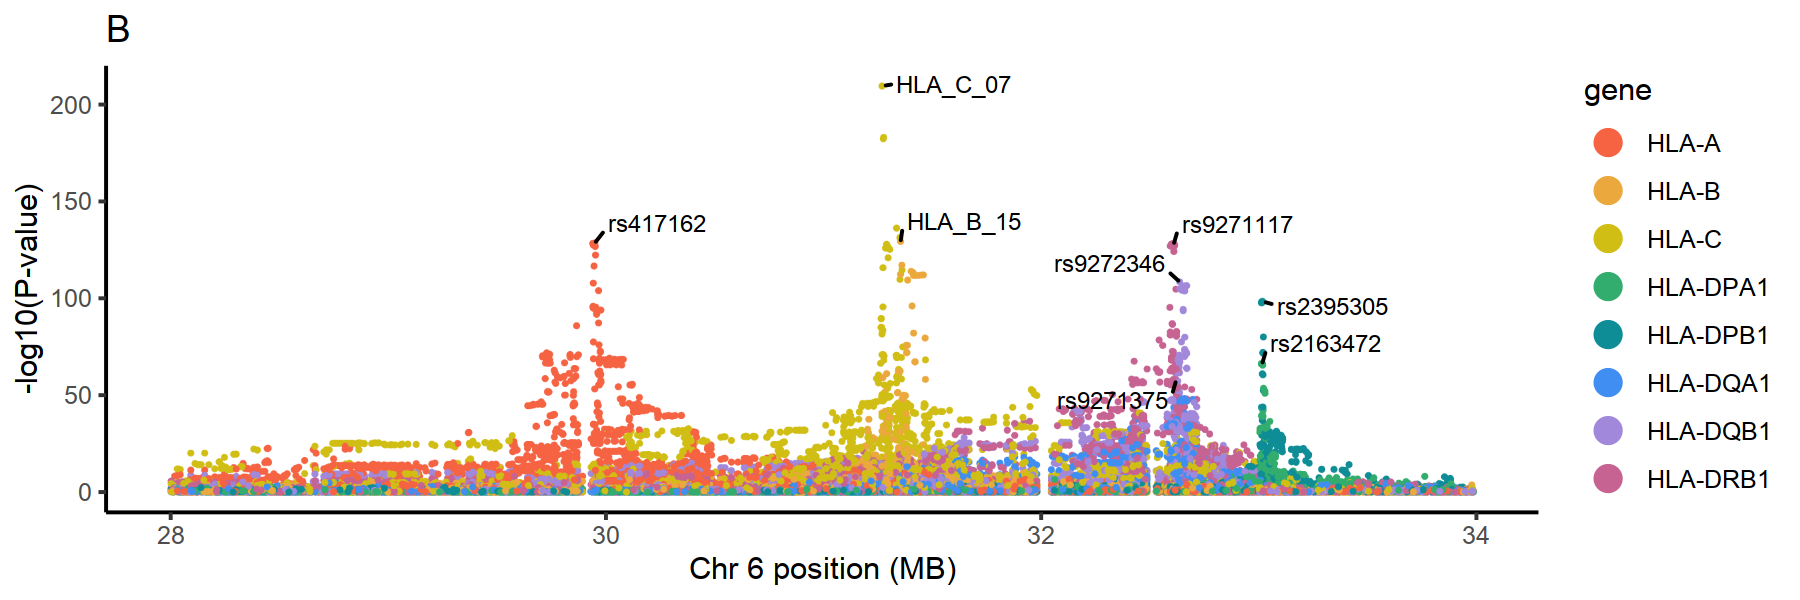

In [4]:
fig.size(3, 9)
p1 = results %>%
        sample_frac(1L) %>%
        ggplot() + geom_point_rast(aes(x = POS / 10^6, y = -log10(p.val), col = gene), size = 0.3) + 
        ylab('-log10(P-value)') + theme_classic() + scale_color_manual(values = gene_colors) +
        xlab('Chr 6 position (MB)') + ggtitle('B') + guides(colour = guide_legend(override.aes = list(size = 4))) +
        geom_text_repel(data = lead_variants, aes(x = POS / 10^6, y = -log10(p.val), 
                        label = variant), size = 3, min.segment.length = 0)
pdf(paste(figures_dir, 'Manhattan_B_plasma.pdf', sep = ''), height = 3, width = 9)
print(p1)
dev.off()
p1

In [5]:
results = results %>% arrange(gene, POS) %>%
                             mutate(beta = round(beta, 3),
                             stderr = round(stderr, 3),
                             t.val = round(t.val, 3),
                             p.val = as.numeric(format(p.val, digits = 4, scientific = TRUE)),
                             AMP2RA_MAF = round(AMP2RA_MAF, 2),
                             Smillie_MAF = round(Smillie_MAF, 2),
                             Randolph_MAF = round(Randolph_MAF, 2),
                             OneK1K_MAF = round(OneK1K_MAF, 2))
write.csv(lead_variants, './4_multidataset_eQTLs/B_plasma_lead_variants.csv', quote = F)
write.csv(results, './4_multidataset_eQTLs/B_plasma_all_variants.csv', quote = F)

png 
  2

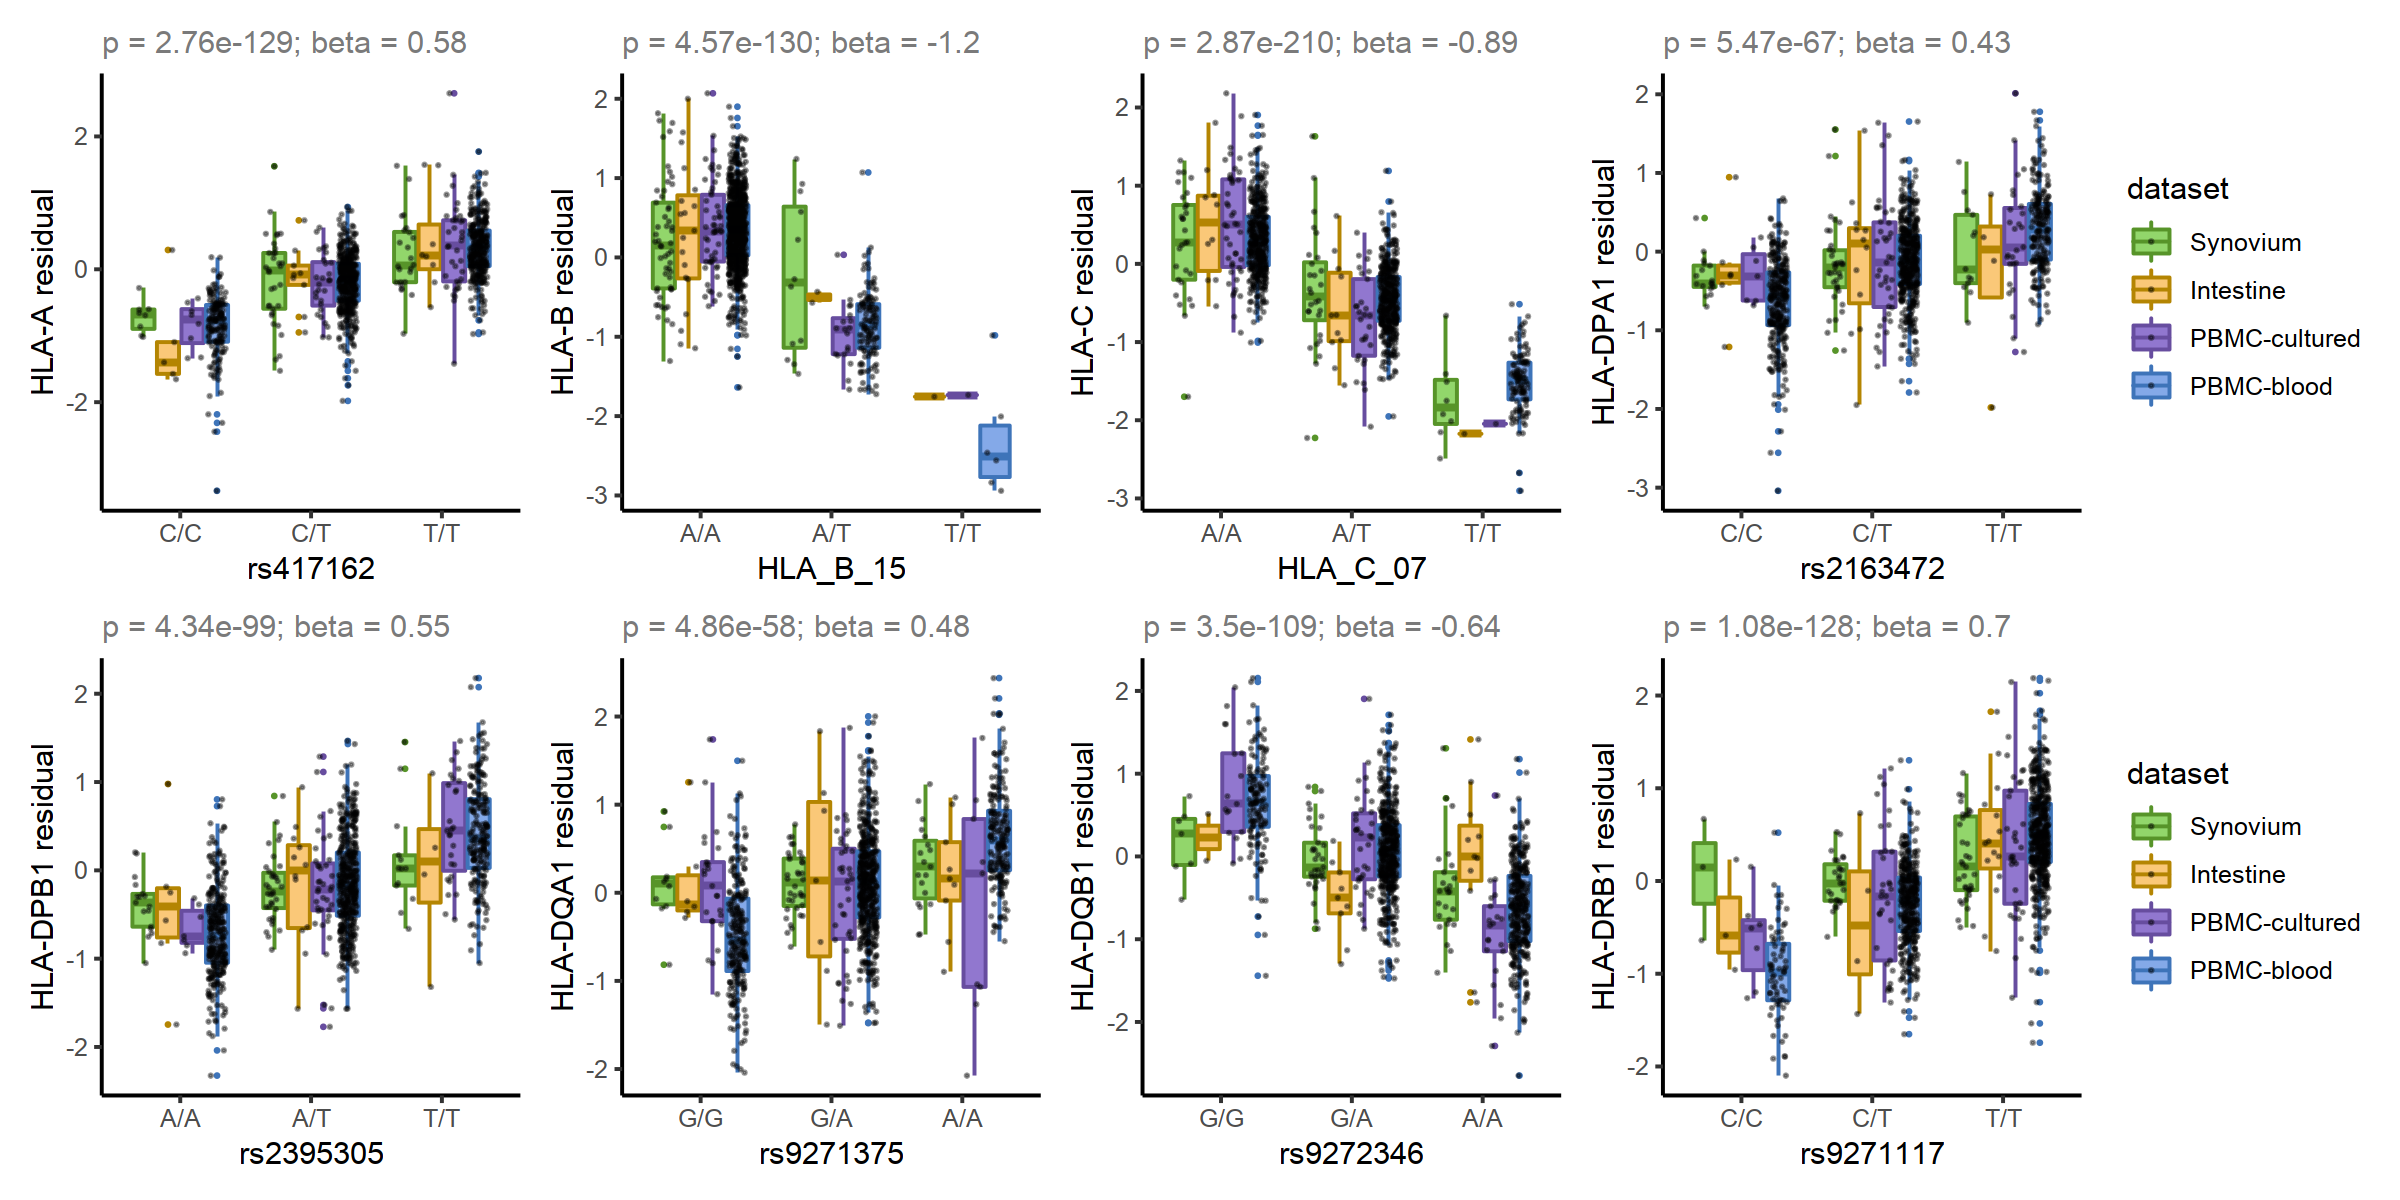

In [7]:
sampleXdosage = readRDS('./4_multidataset_eQTLs/B_plasma_sampleXdosage.rds') 
residuals = readRDS('./4_multidataset_eQTLs/B_plasma_residuals.rds')
colnames(residuals) = str_replace(colnames(residuals), '\\.', '-')
sampleXdosage = sampleXdosage %>% round() %>% as.data.frame()
data = cbind(residuals, sampleXdosage)

pdf(paste(figures_dir, 'Multi_eQTL_boxplots_byDataset_B_plasma.pdf', sep = ''), height=4.5, width=12)
suppressMessages({
p = eqtl_boxplots_dataset(lead_variants) })
print(p)
dev.off()
p

**Check HLA\*C:07**

In [8]:
# Get lead variant for each cell type
results %>% group_by(cell_type, gene) %>% filter(gene == 'HLA-C') %>%
    arrange(p.val) %>% head(4)

variant   cell_type gene  beta   stderr t.val   p.val      CHROM POS      REF
1 HLA_C_07  B         HLA-C -0.886 0.022  -39.423 2.872e-210 chr6  31268774 A  
2 rs2524074 B         HLA-C  0.852 0.024   35.649 8.696e-184 chr6  31276244 G  
3 rs2844619 B         HLA-C  0.829 0.023   35.548 4.462e-183 chr6  31274446 C  
4 rs1634775 B         HLA-C  0.737 0.025   29.031 5.964e-137 chr6  31335459 A  
  ALT DR2  Imputed AMP2RA_MAF Smillie_MAF Randolph_MAF OneK1K_MAF hg19_POS
1 T   0.98 IMP     0.35       0.30        0.21         0.34       31236551
2 A   1.00 TYPED   0.33       0.27        0.20         0.33       31244021
3 G   0.99 IMP     0.41       0.34        0.34         0.38       31242223
4 G   0.99 IMP     0.39       0.32        0.26         0.38       31303236

In [9]:
results %>% group_by(cell_type, gene) %>% filter(gene == 'HLA-C') %>% filter(startsWith(variant, 'HLA_C')) %>%
    arrange(p.val) %>% head(8)

variant     cell_type gene  beta   stderr t.val   p.val      CHROM POS     
1 HLA_C_07    B         HLA-C -0.886 0.022  -39.423 2.872e-210 chr6  31268774
2 HLA_C_07.01 B         HLA-C -0.719 0.037  -19.336  1.262e-71 chr6  31268775
3 HLA_C_07.02 B         HLA-C -0.650 0.043  -15.274  9.039e-48 chr6  31268776
4 HLA_C_06    B         HLA-C  0.748 0.054   13.778  7.317e-40 chr6  31268772
5 HLA_C_06.02 B         HLA-C  0.748 0.054   13.778  7.317e-40 chr6  31268773
6 HLA_C_04.01 B         HLA-C  0.481 0.053    9.041  7.171e-19 chr6  31268763
7 HLA_C_04    B         HLA-C  0.476 0.053    8.948  1.570e-18 chr6  31268762
8 HLA_C_12.03 B         HLA-C  0.526 0.089    5.891  5.151e-09 chr6  31268789
  REF ALT DR2  Imputed AMP2RA_MAF Smillie_MAF Randolph_MAF OneK1K_MAF hg19_POS
1 A   T   0.98 IMP     0.35       0.30        0.21         0.34       31236551
2 A   T   0.97 IMP     0.20       0.14        0.12         0.17       31236552
3 A   T   0.98 IMP     0.13       0.14        0.08         0.15       31236553
4 A   T   0.97 IMP     0.08       0.05        0.08         0.09       31236549
5 A   T   0.97 IMP     0.08       0.05        0.08         0.09       31236550
6 A   T   0.98 IMP     0.10       0.18        0.21         0.10       31236540
7 A   T   0.98 IMP     0.11       0.18        0.21         0.10       31236539
8 A   T   0.94 IMP     0.07       0.05        0.02         0.03       31236566

## Myeloid

In [22]:
results = read.csv('./4_multidataset_eQTLs/Myeloid_pseudobulk_eQTLs.csv', row.names = 1)
results = merge(results, geno_df, by.x = 'variant', by.y = 'ID', all.x = T, all.y = F)
results = results %>% mutate(gene = str_replace(gene, '\\.', '-'), POS = as.numeric(POS)) %>% arrange(POS)
results$X = NULL

# Get lead variant for each cell type
lead_variants = results %>% group_by(cell_type, gene) %>% slice(which.min(p.val))
lead_variants

variant    cell_type gene     beta       stderr     t.val      p.val        
1 rs7747253  Myeloid   HLA-A     0.6255768 0.02405003  26.011480 7.897024e-115
2 HLA_B_15   Myeloid   HLA-B    -1.0015256 0.04940711 -20.270881  4.914031e-77
3 rs2524096  Myeloid   HLA-C     0.6461640 0.02614706  24.712679 4.821300e-106
4 rs17220674 Myeloid   HLA-DPA1 -0.3862375 0.04972647  -7.767242  1.947292e-14
5 rs13203715 Myeloid   HLA-DPB1 -0.2925868 0.03658620  -7.997191  3.434833e-15
6 rs3104413  Myeloid   HLA-DQA1  0.8586673 0.03092705  27.764284 8.039589e-127
7 rs3828789  Myeloid   HLA-DQB1 -0.6889048 0.02441591 -28.215404 6.306445e-130
8 rs9271112  Myeloid   HLA-DRB1  0.2724705 0.02752005   9.900798  3.957589e-22
  CHROM POS      REF ALT DR2  Imputed AMP2RA_MAF Smillie_MAF Randolph_MAF
1 chr6  29952002 C   A   0.99 IMP     0.48550725 0.45454545  0.39041096  
2 chr6  31353886 A   T   0.95 IMP     0.10144928 0.09090909  0.14383562  
3 chr6  31268690 G   T   1.00 TYPED   0.36956522 0.45454545  0.41780822  
4 chr6  33019867 G   A   1.00 TYPED   0.05797101 0.02272727  0.04794521  
5 chr6  33020811 A   G   1.00 TYPED   0.10869565 0.11431818  0.12328767  
6 chr6  32614873 C   G   0.99 IMP     0.31159420 0.09113636  0.13698630  
7 chr6  32667977 G   T   1.00 TYPED   0.36231884 0.31818182  0.47260274  
8 chr6  32608940 T   C   1.00 TYPED   0.24637681 0.22772727  0.30821918  
  OneK1K_MAF hg19_POS
1 0.48899890 29919779
2 0.07150715 31321663
3 0.42354235 31236467
4 0.04400440 32987644
5 0.11771177 32988588
6 0.19746975 32582650
7 0.39328933 32635754
8 0.27062706 32576717

png 
  2

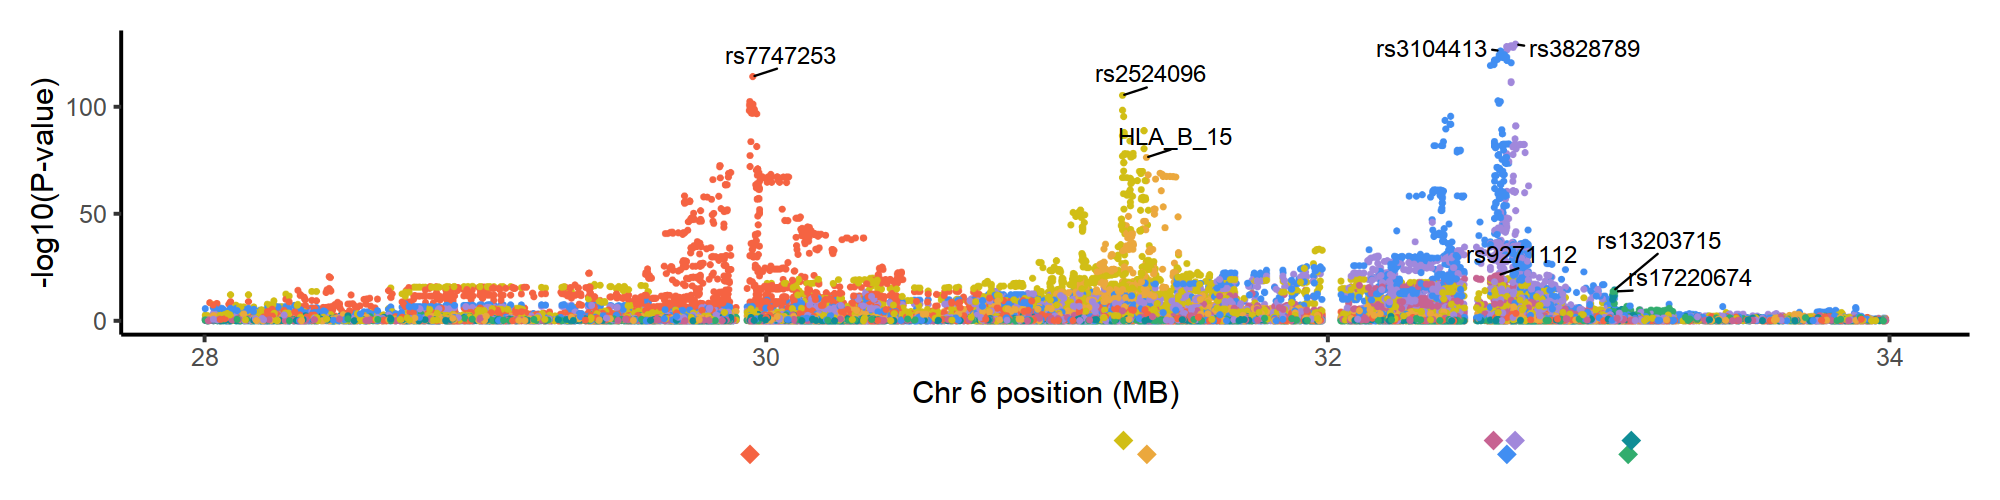

In [23]:
fig.size(2.5, 10)

set.seed(1)
p1 = results %>% 
        sample_frac(1L) %>% #shuffle
        ggplot() +
        geom_point_rast(aes(x = POS / 10^6, y = -log10(p.val), col = gene), size = 0.3) + 
        ylab('-log10(P-value)') + theme_classic() + xlab('Chr 6 position (MB)') +
        scale_color_manual(values = gene_colors) +
        theme(legend.position = 'none') + 
        guides(colour = guide_legend(override.aes = list(size = 4))) +
        geom_text_repel(data = lead_variants, aes(x = POS / 10^6, y = -log10(p.val), 
                               label = variant), size = 3, segment.size = 0.3, 
                               min.segment.length = 0, nudge_y = 10, nudge_x = 0.1) +
        xlim(28.002253, 33.985869)
p2 = ggplot(gtf_hla) +
        geom_point(aes(x = TSS / 10^6, y = plot_pos, col = hla_gene), size = 3, shape = 18) + 
        scale_color_manual(values = gene_colors) +
        theme_void() + theme(legend.position = 'none') + 
        xlim(28.002253, 33.985869) + ylim(-1, 1)

pdf(paste0(figures_dir, 'Manhattan_Myeloid.pdf', sep = ''), height=2.5, width=10)
print(p1 / p2  + plot_layout(heights = c(5, 1)))
dev.off()
p1 / p2  + plot_layout(heights = c(5, 1))

In [24]:
results = results %>% arrange(gene, POS) %>%
                             mutate(beta = round(beta, 3),
                             stderr = round(stderr, 3),
                             t.val = round(t.val, 3),
                             p.val = as.numeric(format(p.val, digits = 4, scientific = TRUE)),
                             AMP2RA_MAF = round(AMP2RA_MAF, 2),
                             Smillie_MAF = round(Smillie_MAF, 2),
                             Randolph_MAF = round(Randolph_MAF, 2),
                             OneK1K_MAF = round(OneK1K_MAF, 2))
write.csv(lead_variants, './4_multidataset_eQTLs/Myeloid_lead_variants.csv', quote = F)
write.csv(results, './4_multidataset_eQTLs/Myeloid_all_variants.csv', quote = F)

In [25]:
sampleXdosage = readRDS('./4_multidataset_eQTLs/Myeloid_sampleXdosage.rds') 
residuals = readRDS('./4_multidataset_eQTLs/Myeloid_residuals.rds')
colnames(residuals) = str_replace(colnames(residuals), '\\.', '-')

sampleXdosage = sampleXdosage %>% round() %>% as.data.frame()
data = cbind(residuals, sampleXdosage)
data$dataset = factor(data$dataset, levels = c('AMP2RA', 'Smillie', 'Randolph_NI', 'OneK1K'))

png 
  2

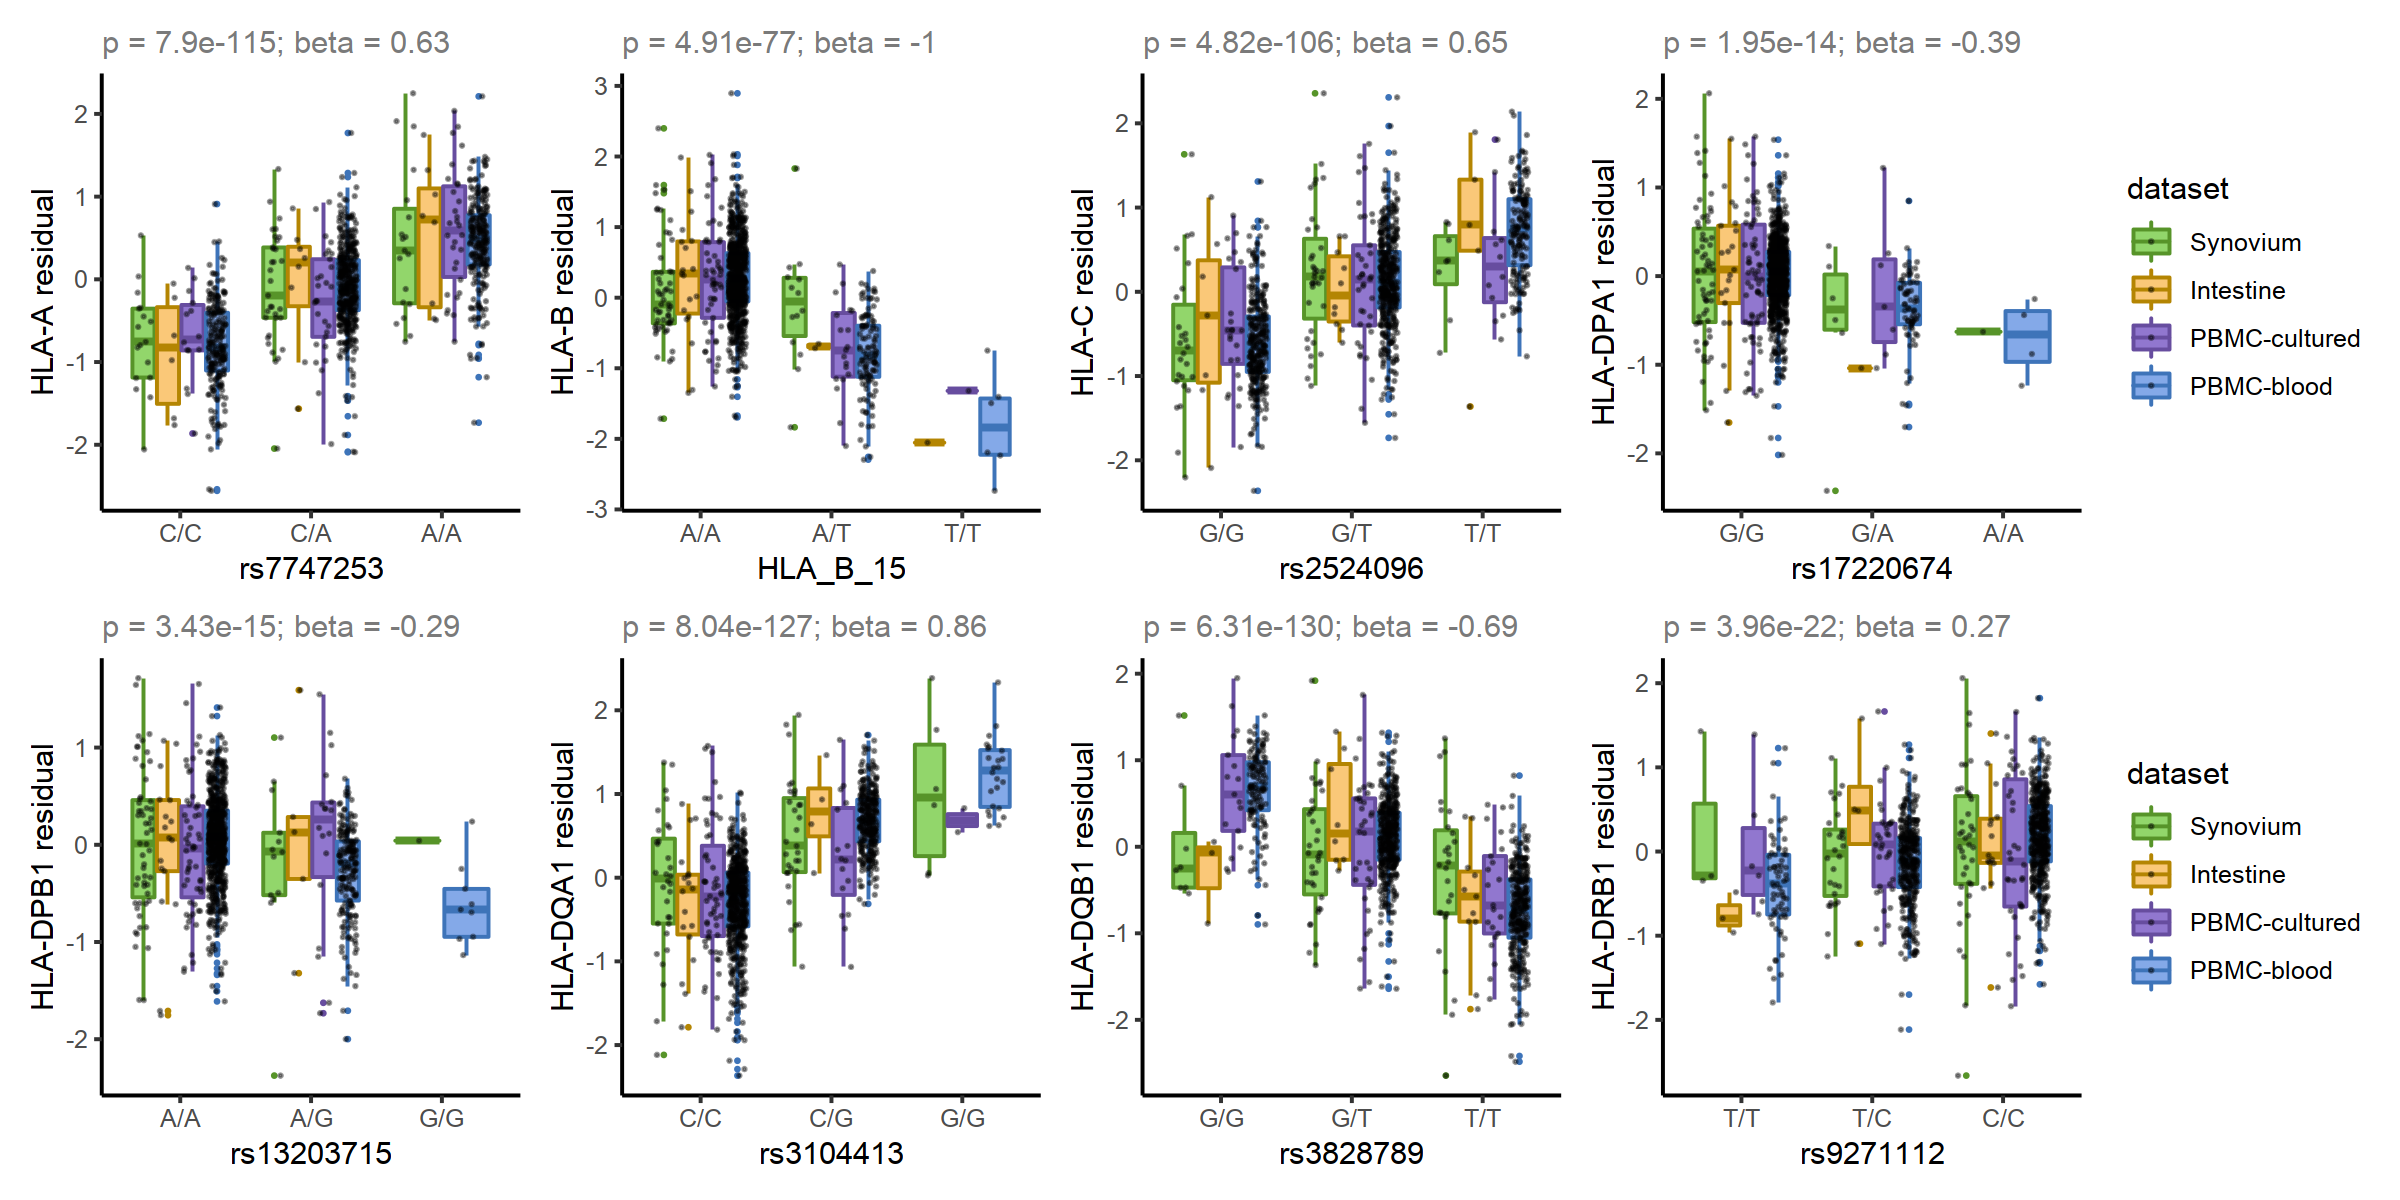

In [26]:
pdf(paste(figures_dir, 'Multi_eQTL_boxplots_byDataset_Myeloid.pdf', sep = ''), height=4.5, width=12)
suppressMessages({
p = eqtl_boxplots_dataset(lead_variants) })
print(p)
dev.off()
p

## T

In [14]:
results = read.csv('./4_multidataset_eQTLs/T_pseudobulk_eQTLs.csv', row.names = 1) %>%
    mutate(cell_type = 'T')
results = merge(results, geno_df, by.x = 'variant', by.y = 'ID', all.x = T, all.y = F)
results = results %>% mutate(gene = str_replace(gene, '\\.', '-'), POS = as.numeric(POS)) %>% arrange(POS)
results$X = NULL

# Get lead variant for each cell type
lead_variants = results %>% group_by(cell_type, gene) %>% slice(which.min(p.val))
lead_variants

variant        cell_type gene     beta       stderr     t.val     
1 rs7747253      T         HLA-A     0.4181636 0.01532622  27.284202
2 HLA_B_15       T         HLA-B    -1.2555508 0.03685291 -34.069246
3 rs2395471      T         HLA-C     0.5390546 0.02069677  26.045344
4 HLA_DPB1_04.02 T         HLA-DPA1 -0.3010711 0.02884233 -10.438514
5 rs1431403      T         HLA-DPB1  0.1839142 0.02088766   8.804918
6 rs3104371      T         HLA-DQA1  0.9034406 0.03124343  28.916174
7 rs9272271      T         HLA-DQB1 -0.5883969 0.03250027 -18.104369
8 rs17205184     T         HLA-DRB1 -0.1576231 0.02645052  -5.959167
  p.val         CHROM POS      REF ALT DR2  Imputed AMP2RA_MAF Smillie_MAF
1 8.949243e-125 chr6  29952002 C   A   0.99 IMP     0.4855072  0.45454545 
2 9.369418e-173 chr6  31353886 A   T   0.95 IMP     0.1014493  0.09090909 
3 3.735962e-116 chr6  31272915 G   A   1.00 TYPED   0.3695652  0.50000000 
4  2.350763e-24 chr6  33075935 A   T   0.98 IMP     0.0942029  0.13204545 
5  5.196738e-18 chr6  33079254 T   C   1.00 TYPED   0.3405797  0.25772727 
6 3.113797e-136 chr6  32634360 C   G   0.99 IMP     0.3188406  0.11363636 
7  4.313160e-64 chr6  32635749 A   T   1.00 TYPED   0.2536232  0.40863636 
8  3.440293e-09 chr6  32634774 G   A   1.00 TYPED   0.1884058  0.09090909 
  Randolph_MAF OneK1K_MAF hg19_POS
1 0.3904110    0.48899890 29919779
2 0.1438356    0.07150715 31321663
3 0.4794521    0.36633663 31240692
4 0.1369863    0.10176018 33043712
5 0.4520548    0.29097910 33047031
6 0.1506849    0.21012101 32602137
7 0.2534247    0.25412541 32603526
8 0.1575342    0.20297030 32602551

png 
  2

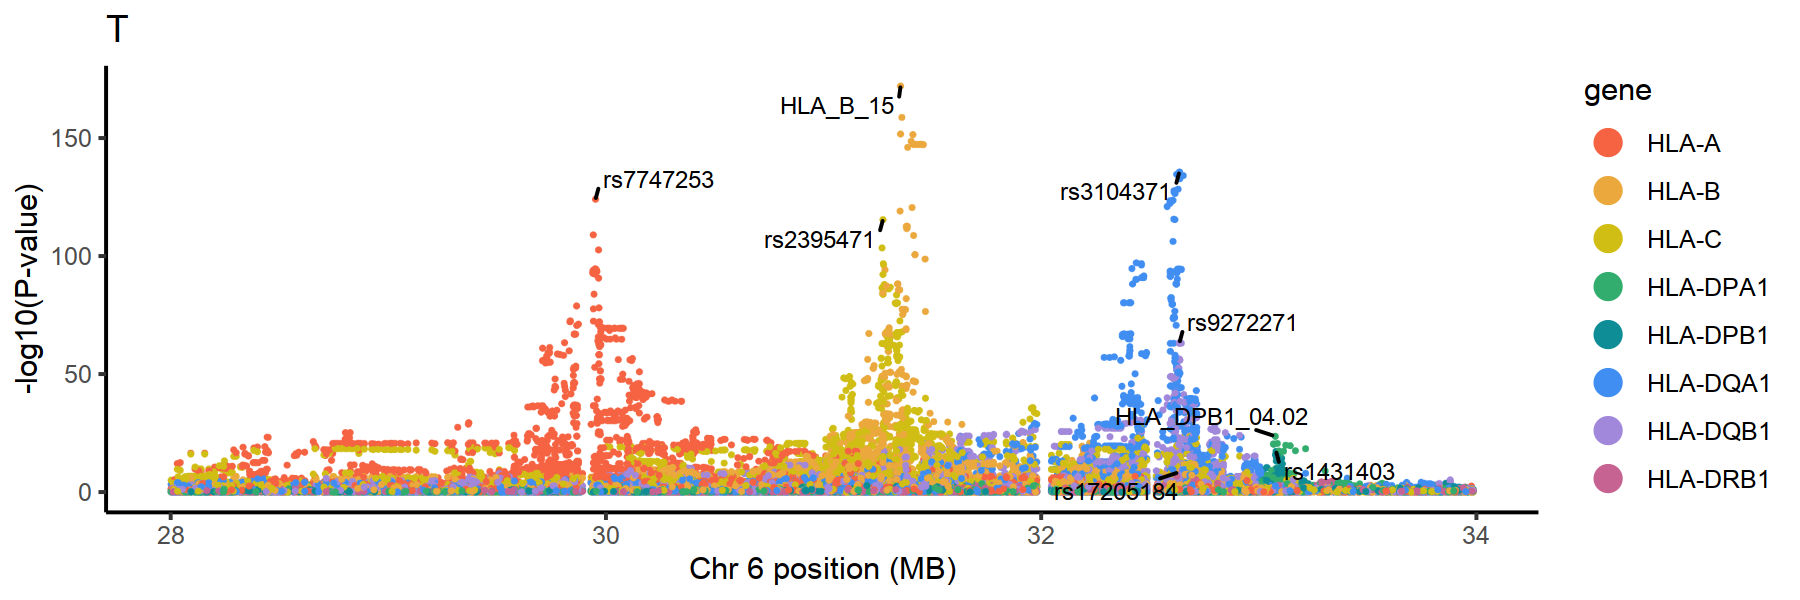

In [15]:
fig.size(3, 9)

p1 = results %>% 
        sample_frac(1L) %>% # shuffle
        ggplot() +
        geom_point_rast(aes(x = POS / 10^6, y = -log10(p.val), col = gene), size = 0.3) + 
        #geom_hline(yintercept=thresh, col = 'black', linetype = 'dashed') +
        ylab('-log10(P-value)') + theme_classic() + scale_color_manual(values = gene_colors) +
        xlab('Chr 6 position (MB)') + ggtitle('T') + guides(colour = guide_legend(override.aes = list(size = 4))) +
        geom_text_repel(data = lead_variants, aes(x = POS / 10^6, y = -log10(p.val), 
                                                  label = variant), size = 3, min.segment.length = 0)
pdf(paste0(figures_dir, 'Manhattan_T.pdf'), height=3, width=9)
print(p1)
dev.off()
p1

In [16]:
results = results %>% arrange(gene, POS) %>%
                             mutate(beta = round(beta, 3),
                             stderr = round(stderr, 3),
                             t.val = round(t.val, 3),
                             p.val = as.numeric(format(p.val, digits = 4, scientific = TRUE)),
                             AMP2RA_MAF = round(AMP2RA_MAF, 2),
                             Smillie_MAF = round(Smillie_MAF, 2),
                             Randolph_MAF = round(Randolph_MAF, 2),
                             OneK1K_MAF = round(OneK1K_MAF, 2))
write.csv(lead_variants, './4_multidataset_eQTLs/T_lead_variants.csv', quote = F)
write.csv(results, './4_multidataset_eQTLs/T_all_variants.csv', quote = F)

png 
  2

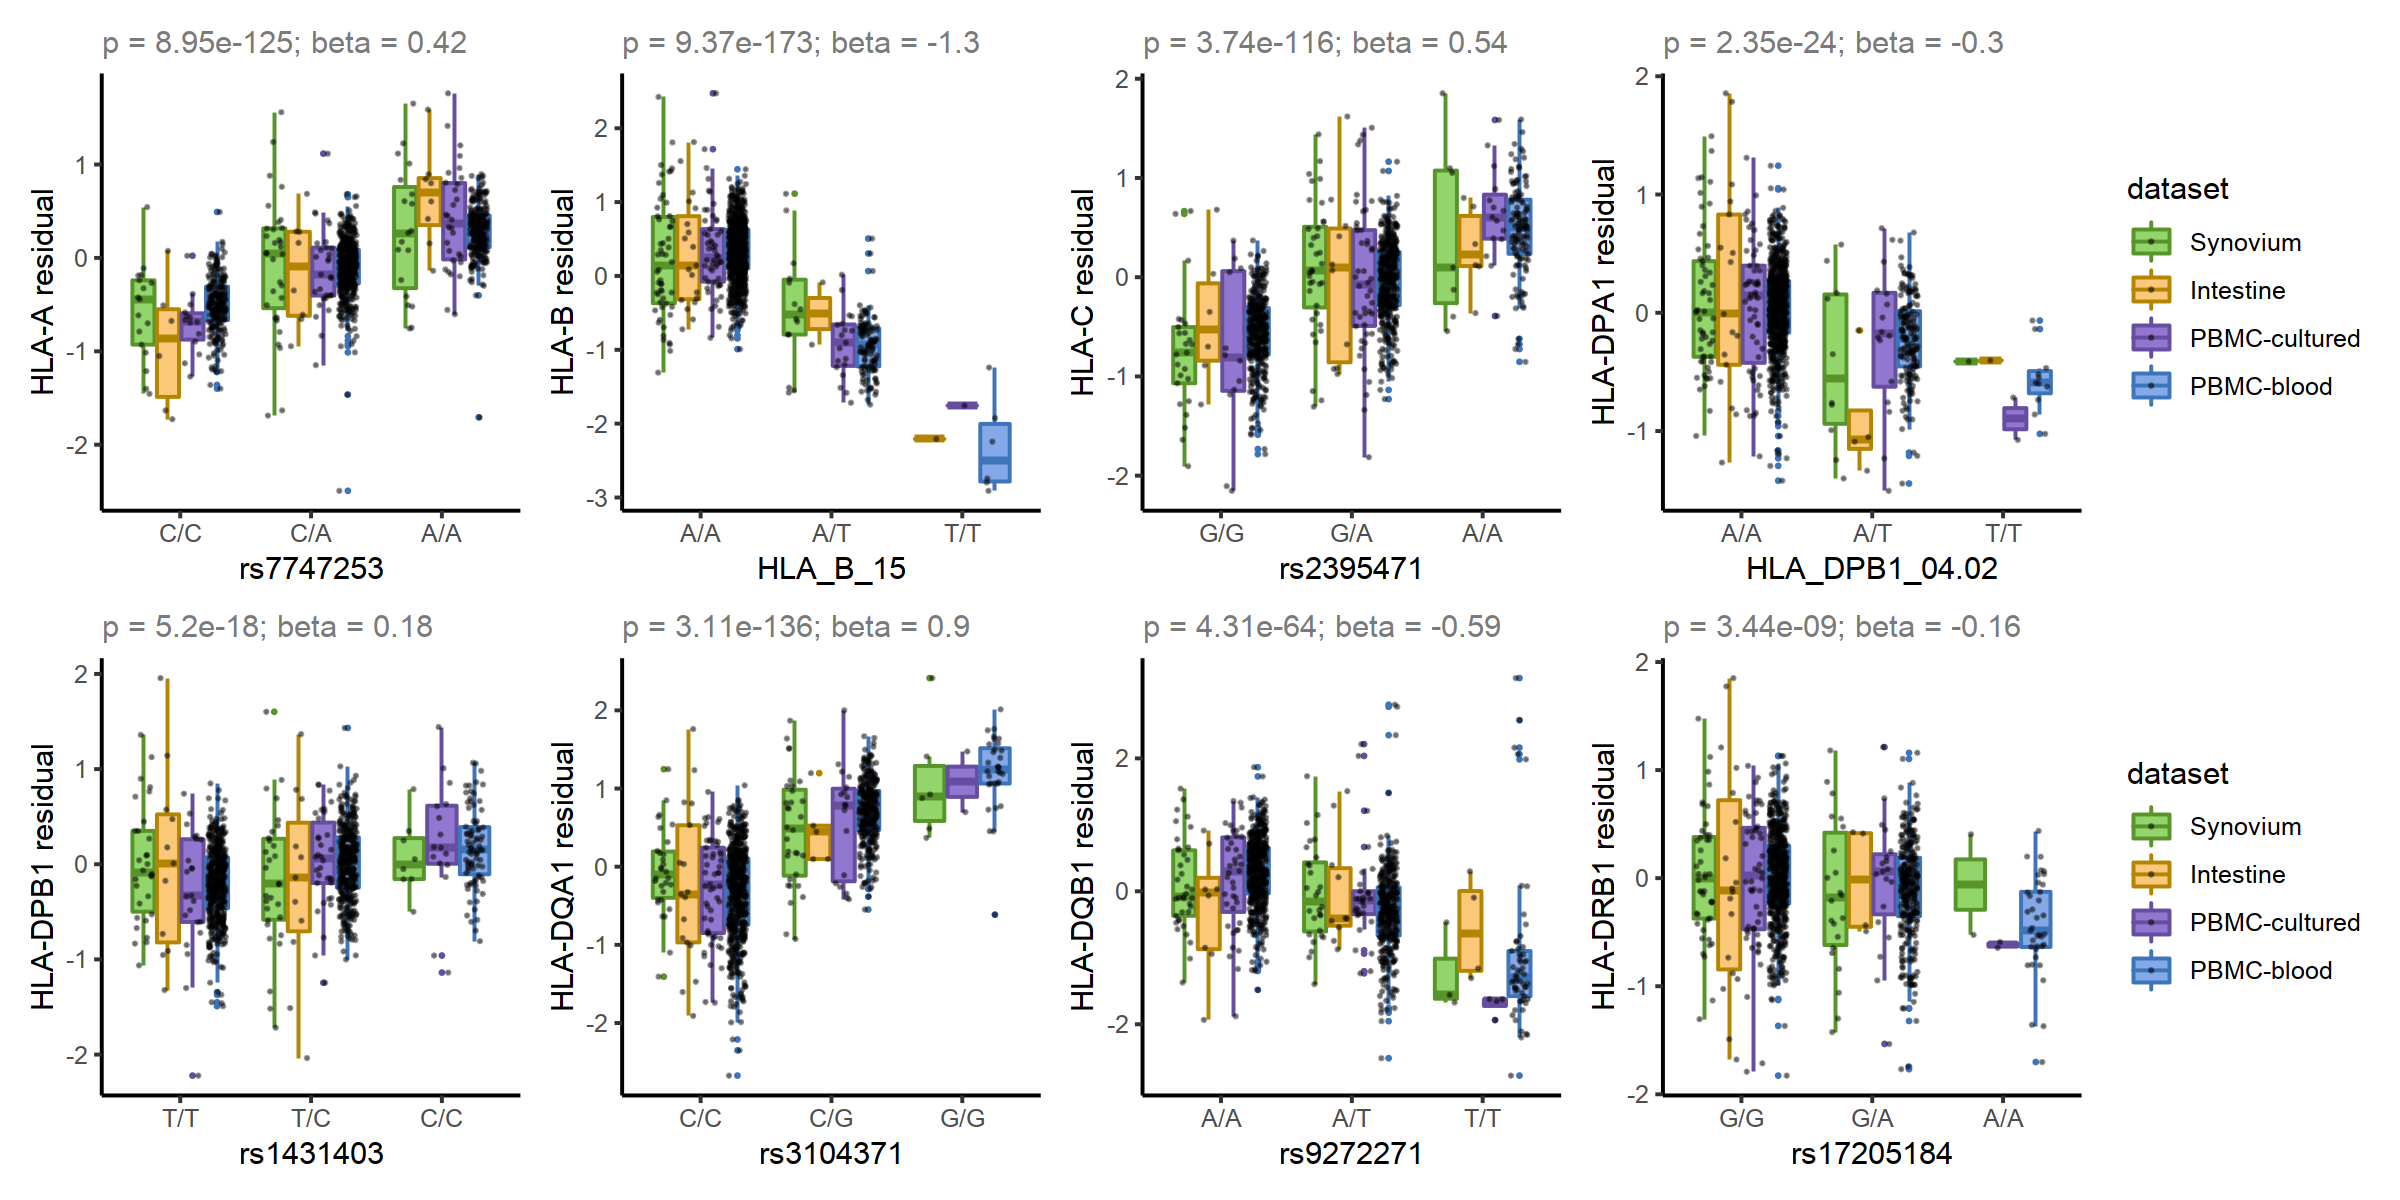

In [17]:
sampleXdosage = readRDS('./4_multidataset_eQTLs/T_sampleXdosage.rds') 
residuals = readRDS('./4_multidataset_eQTLs/T_residuals.rds')
colnames(residuals) = str_replace(colnames(residuals), '\\.', '-')

sampleXdosage = sampleXdosage %>% round() %>% as.data.frame()
data = cbind(residuals, sampleXdosage)
data$dataset = factor(data$dataset, levels = c('AMP2RA', 'Smillie', 'Randolph_NI', 'OneK1K'))

pdf(paste(figures_dir, 'Multi_eQTL_boxplots_byDataset_T.pdf', sep = ''), height=4.5, width=12)
suppressMessages({
p = eqtl_boxplots_dataset(lead_variants) })
print(p)
dev.off()
p

## Write supp table

In [25]:
tab = rbind(read.csv('4_multidataset_eQTLs/B_plasma_all_variants.csv', row.names = 1),
            read.csv('4_multidataset_eQTLs/Myeloid_all_variants.csv', row.names = 1),
            read.csv('4_multidataset_eQTLs/T_all_variants.csv', row.names = 1) %>% mutate(cell_type = 'T'))
tab = tab %>% dplyr::select(variant, cell_type, gene, beta, stderr, p.val, REF, ALT)
write.csv(tab, '../SuppTables/table_multidataset_pseudobulk_all.csv', quote = F, row.names = F)

Psoriasis alleles

In [26]:
tab %>% filter(variant %in% c('HLA_C_12.03', 'HLA_C_06.02') , gene == 'HLA-C')

variant     cell_type gene  beta  stderr p.val     REF ALT
1 HLA_C_06.02 B         HLA-C 0.748 0.054  7.317e-40 A   T  
2 HLA_C_12.03 B         HLA-C 0.526 0.089  5.151e-09 A   T  
3 HLA_C_06.02 Myeloid   HLA-C 0.967 0.052  1.267e-67 A   T  
4 HLA_C_12.03 Myeloid   HLA-C 0.499 0.088  2.060e-08 A   T  
5 HLA_C_06.02 T         HLA-C 0.711 0.039  1.123e-63 A   T  
6 HLA_C_12.03 T         HLA-C 0.564 0.067  1.838e-16 A   T

In [27]:
tab = rbind(read.csv('4_multidataset_eQTLs/B_plasma_lead_variants.csv', row.names = 1),
            read.csv('4_multidataset_eQTLs/Myeloid_lead_variants.csv', row.names = 1),
            read.csv('4_multidataset_eQTLs/T_lead_variants.csv', row.names = 1) %>% mutate(cell_type = 'T'))
tab = tab %>% dplyr::select(variant, cell_type, gene, beta, stderr, p.val, POS, REF, ALT)
gtf_hla = readRDS('./gtf_hla.rds')
gtf_hla$gene = gtf_hla$gene_name
gtf_hla$gene_name = NULL

In [28]:
tab = left_join(tab, gtf_hla)
head(tab)
tab = tab %>% mutate(dist_from_TSS = POS - TSS)
write.csv(tab, 'tab.csv', quote = F, row.names = F)

Joining, by = "gene"


variant   cell_type gene     beta       stderr     p.val         POS      REF
1 rs417162  B         HLA-A     0.5767157 0.02064114 2.762306e-129 29948728 C  
2 HLA_B_15  B         HLA-B    -1.1788444 0.04202419 4.570277e-130 31353886 A  
3 HLA_C_07  B         HLA-C    -0.8859126 0.02247189 2.872157e-210 31268774 A  
4 rs2163472 B         HLA-DPA1  0.4320438 0.02324674  5.470229e-67 33015598 C  
5 rs2395305 B         HLA-DPB1  0.5474434 0.02323828  4.343055e-99 33017599 A  
6 rs9271375 B         HLA-DQA1  0.4792688 0.02804572  4.856008e-58 32619290 G  
  ALT TSS      width strand
1 T   29942245 3640  +     
2 T   31355404  904  -     
3 T   31272086 3338  -     
4 T   33069248 1589  -     
5 T   33080487 5403  +     
6 A   32637401 6252  +

# Plot conditional eQTLs

In [36]:
gtf_hla = readRDS('gtf_hla.rds')
eQTL_colors = c("Primary" = "#2C1320",
                "Secondary" = "#966b9d", 
                "Tertiary" = "#d1c6ad",
                "Quaternary" = "grey48")

In [37]:
# rs9272294 for DQA1
32637401 - 32635983

[1] 1418

## B

In [50]:
## Read in primary, secondary, and tertiary eQTLs
results_primary = read.csv('./4_multidataset_eQTLs/B_plasma_all_variants.csv', row.names = 1) %>% 
    mutate(gene = str_replace(gene, '-', '\\.'))
results_secondary = read.csv('./6_multidataset_conditional/B_plasma_secondary_all_variants.csv', row.names = 1) 
results_tertiary = read.csv('./6_multidataset_conditional/B_plasma_tertiary_all_variants.csv', row.names = 1)
results_quaternary = read.csv('./6_multidataset_conditional/B_plasma_quaternary_all_variants.csv', row.names = 1)

results_primary$conditional_iter = 0
results = rbind.fill(results_primary, results_secondary, results_tertiary, results_quaternary) %>% mutate(cell_type = 'B')

## Add column for which iteration
results = results %>% mutate(eQTL = case_when(
                            conditional_iter == 0 ~ "Primary", 
                            conditional_iter == 1 ~ "Secondary",
                            conditional_iter == 2 ~ "Tertiary",
                            conditional_iter == 3 ~ "Quaternary"))
results$eQTL = factor(results$eQTL, levels = rev(c('Quaternary', 'Tertiary', 'Secondary', 'Primary')))
results$POS = as.numeric(results$POS)
results$hg19_POS = NULL

## Add gtf information
results = left_join(results, gtf_hla, all.x = T, all.y = F) %>% 
                        mutate(dist_from_TSS = POS - TSS) %>%
                        filter(abs(dist_from_TSS) < 2e6)

# Label REF and ALT for variants (but not HLA alleles)
results$ID = results$variant
results = results %>% mutate(
           variant = ifelse(startsWith(results$variant, 'HLA'), variant, paste(variant, REF, ALT, sep = '_')))

# Get lead variant for each cell type
results$POS = as.numeric(results$POS)
lead_variants = results %>% group_by(cell_type, gene, conditional_iter) %>% 
    slice(which.min(p.val)) %>%
    filter(p.val < 5e-8) %>% # filter to 5e-8 cutoff
    mutate(dist_from_TSS = as.numeric(POS) - TSS)

results = results %>% mutate(lead_status = case_when(
                            paste(variant, cell_type, gene, conditional_iter) %in% 
                            paste(lead_variants$variant, lead_variants$cell_type, lead_variants$gene, lead_variants$conditional_iter) 
                            ~ "Lead",
                            TRUE ~ "none"))

table(results$lead_status)

Joining, by = "gene"



  Lead   none 
    24 265032 

png 
  2

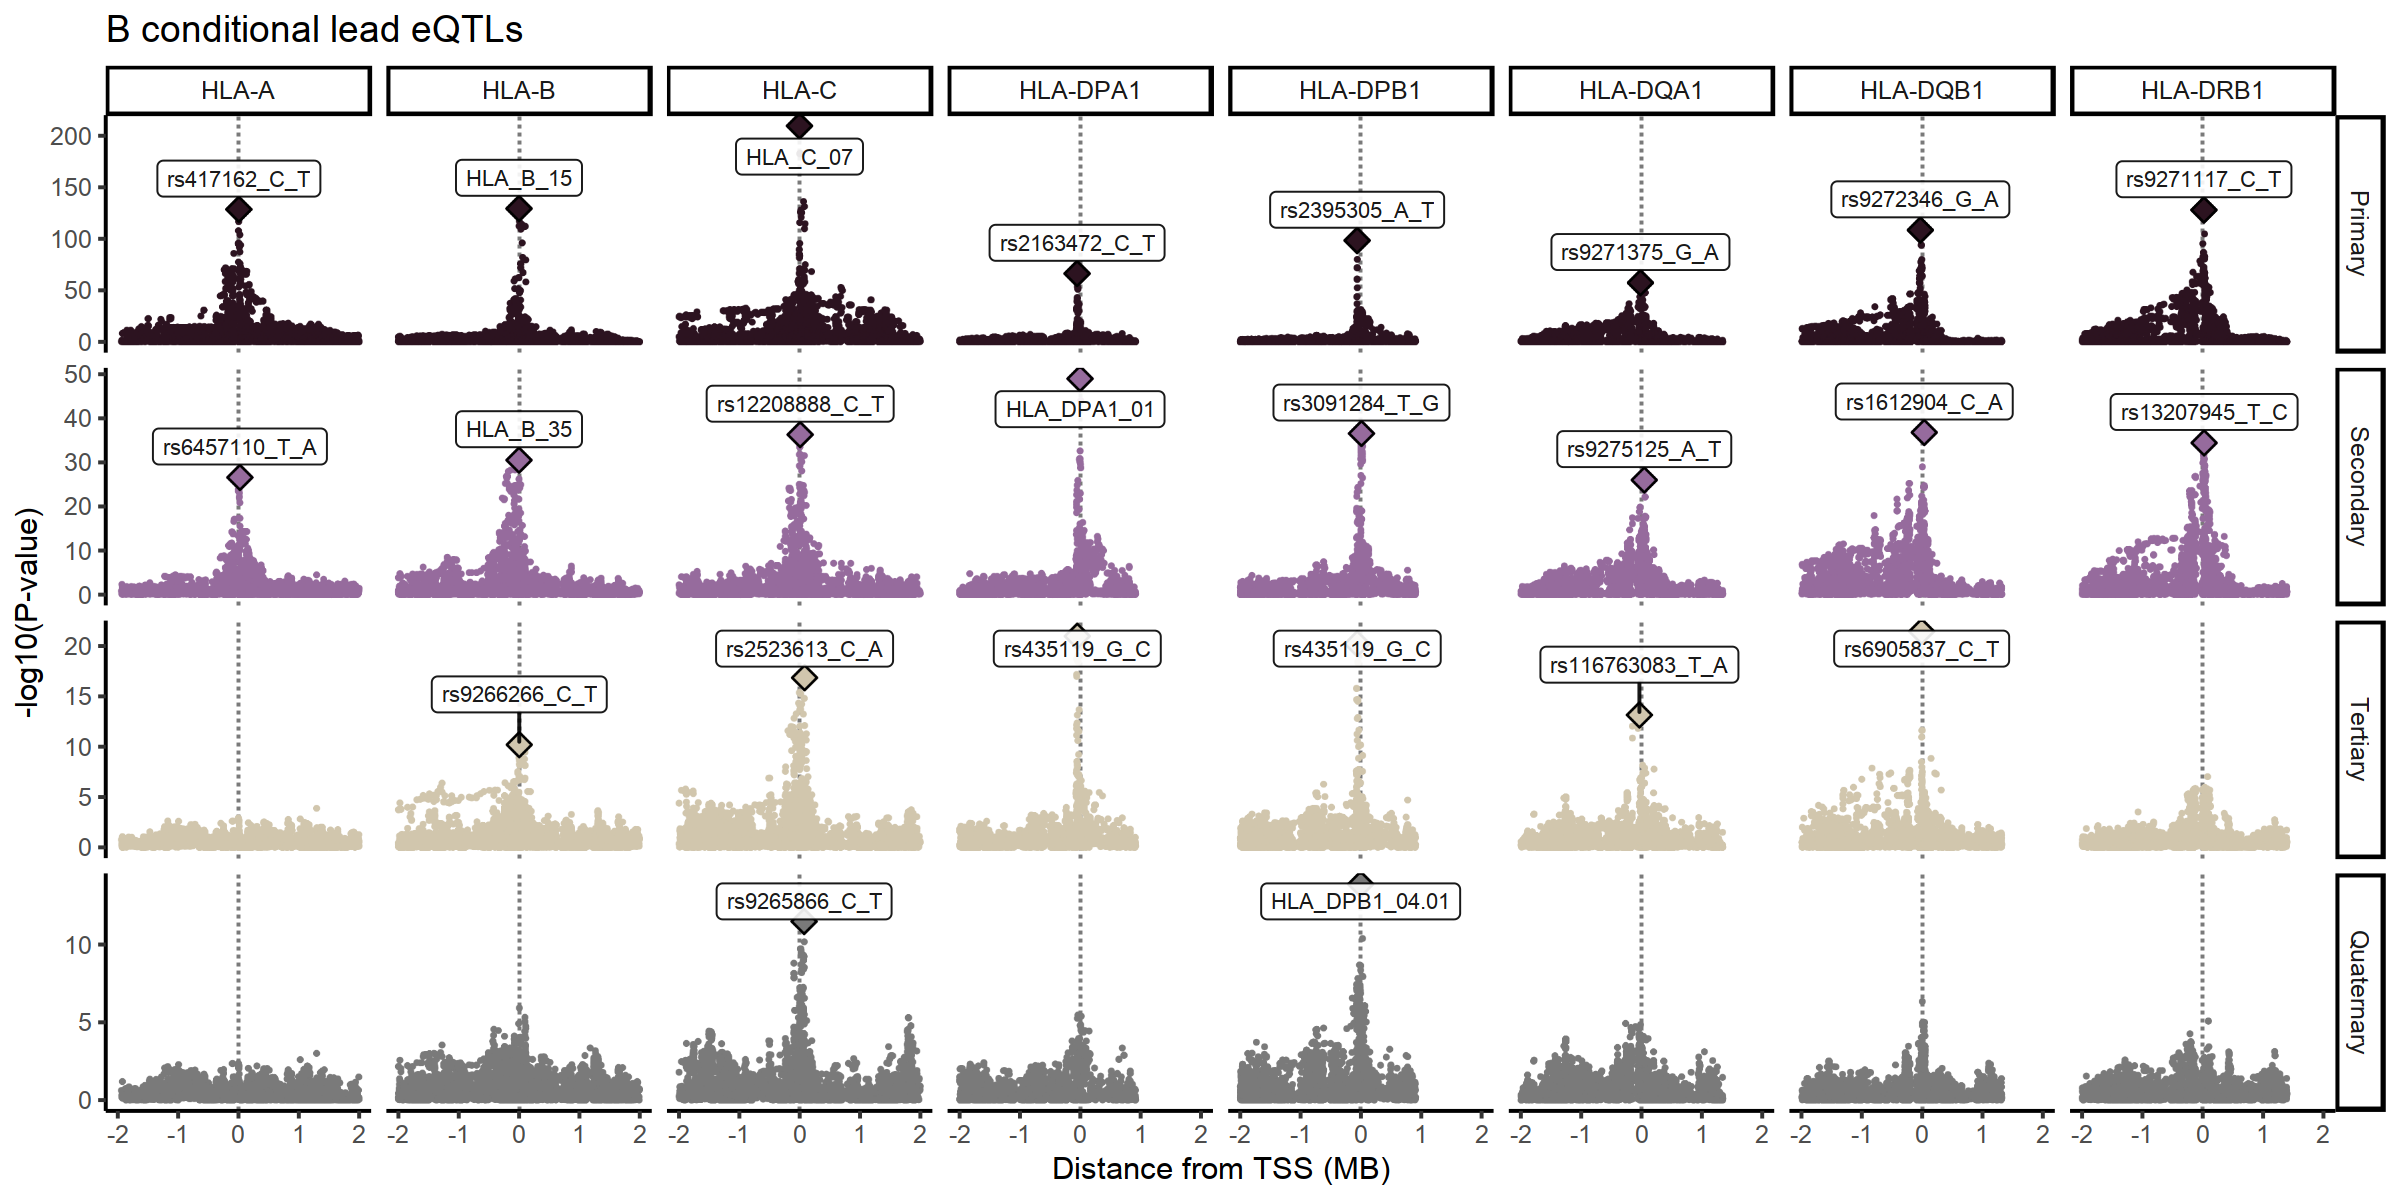

In [51]:
fig.size(6, 12)

pdf(paste0('../SuppFigs/conditional_pseudobulk_eQTLs_colorby_conditional_B.pdf'), height=6, width=12)

results$gene = str_replace(results$gene, '\\.', '-')
lead_to_label = results %>% filter(lead_status == 'Lead')
# Add newlines at 4th "_"
for (i in 1:nrow(lead_to_label)) {
    if (startsWith(lead_to_label$variant[i], 'SNPS')){
        str_vec <- strsplit(lead_to_label$variant[i], "_")[[1]] 
        where <- seq_along(str_vec) == 4
        str_vec[where] <- sub("", "\n", str_vec[where])
        lead_to_label$variant[i] = paste(str_vec, collapse="_")
    }
}

p = results %>% 
        ggplot() + geom_vline(xintercept = 0, linetype = 'dashed', col = 'grey48') +
        
        # plot all variants
        geom_point_rast(aes(x = dist_from_TSS / 1e6, y = -log10(p.val), fill = eQTL,
                            col = eQTL, size = lead_status, shape = lead_status)) +
        xlab('Distance from TSS (MB)') + scale_color_manual(values = eQTL_colors) + scale_fill_manual(values = eQTL_colors) +
        guides(fill = guide_legend(override.aes = list(size = 3))) + guides(shape = "none", size = "none") +
        
        # plot lead variant with diamond
        geom_point_rast(data = lead_to_label, aes(x = dist_from_TSS / 1e6, y = -log10(p.val), 
                            fill = eQTL, size = lead_status, shape = lead_status), col = 'black') + 
        # formatting
        ylab('-log10(P-value)') + theme_classic() + theme(legend.position = 'none') +
        facet_grid(eQTL ~ factor(gene), scales = 'free_y') +
        scale_size_manual(values = c(3, 0.6)) + scale_shape_manual(values = c(23, 20)) + 
        
        geom_label_repel(data = lead_to_label, 
                                aes(x = dist_from_TSS / 1e6, y = -log10(p.val), label = variant), size = 2.75, alpha = 0.9, nudge_y = 5) +
        ggtitle('B conditional lead eQTLs')
print(p)
dev.off()
p

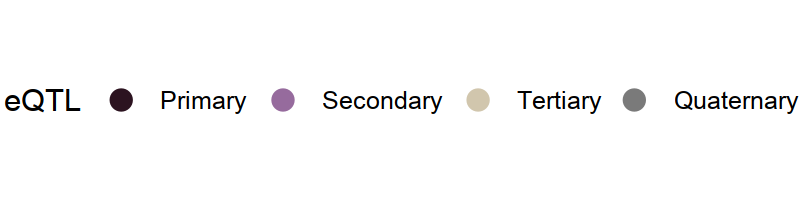

In [52]:
fig.size(1, 4)

p = results %>% 
        ggplot() +
        #plot all
        geom_point_rast(aes(x = dist_from_TSS / 1e6, y = -log10(p.val), fill = eQTL,
                            col = eQTL, size = lead_status, shape = lead_status)) +
        xlab('Distance from TSS (MB)') + scale_color_manual(values = eQTL_colors) + scale_fill_manual(values = eQTL_colors) +
        guides(fill = guide_legend(override.aes = list(size = 3))) + guides(shape = "none", size = "none") +
        ylab('-log10(P-value)') + theme_classic() + theme(legend.position = 'bottom') +
        scale_size_manual(values = c(4, 0.6)) + scale_shape_manual(values = c(23, 20))
as_ggplot(get_legend(p))
ggsave(paste0('../SuppFigs/conditional_pseudobulk_eQTLs_legend.pdf'), 
       height=1, width=4, useDingbats = FALSE)

In [53]:
B_lead_variants = lead_variants
B_results = results

## Myeloid

In [54]:
## Read in primary, secondary, and tertiary eQTLs
results_primary = read.csv('./4_multidataset_eQTLs/Myeloid_all_variants.csv', row.names = 1) %>% 
    mutate(gene = str_replace(gene, '-', '\\.'))
results_secondary = read.csv('./6_multidataset_conditional/Myeloid_secondary_all_variants.csv', row.names = 1)
results_tertiary = read.csv('./6_multidataset_conditional/Myeloid_tertiary_all_variants.csv', row.names = 1)
results_quaternary = read.csv('./6_multidataset_conditional/Myeloid_quaternary_all_variants.csv', row.names = 1)

results_primary$conditional_iter = 0
results = rbind.fill(results_primary, results_secondary, results_tertiary, results_quaternary)

## Add column for which iteration
results = results %>% mutate(eQTL = case_when(
                            conditional_iter == 0 ~ "Primary", 
                            conditional_iter == 1 ~ "Secondary",
                            conditional_iter == 2 ~ "Tertiary",
                            conditional_iter == 3 ~ "Quaternary"))
results$eQTL = factor(results$eQTL, levels = rev(c('Quaternary', 'Tertiary', 'Secondary', 'Primary')))
results$POS = as.numeric(results$POS)
results$hg19_POS = NULL

## Add gtf information
results = left_join(results, gtf_hla, all.x = T, all.y = F) %>% 
                        mutate(dist_from_TSS = POS - TSS) %>%
                        filter(abs(dist_from_TSS) < 2e6)

# Label REF and ALT for variants (but not HLA alleles)
results$ID = results$variant
results = results %>% mutate(
           variant = ifelse(startsWith(results$variant, 'HLA'), variant, paste(variant, REF, ALT, sep = '_')))

# Get lead variant for each cell type
results$POS = as.numeric(results$POS)
lead_variants = results %>% group_by(cell_type, gene, conditional_iter) %>% 
    slice(which.min(p.val)) %>%
    filter(p.val < 5e-8) %>% # filter to 5e-8 cutoff
    mutate(dist_from_TSS = as.numeric(POS) - TSS)

results = results %>% mutate(lead_status = case_when(
                            paste(variant, cell_type, gene, conditional_iter) %in% 
                            paste(lead_variants$variant, lead_variants$cell_type, 
                                  lead_variants$gene, lead_variants$conditional_iter) ~ "Lead",
                            TRUE ~ "none"))

table(results$lead_status)

Joining, by = "gene"



  Lead   none 
    18 265018 

png 
  2

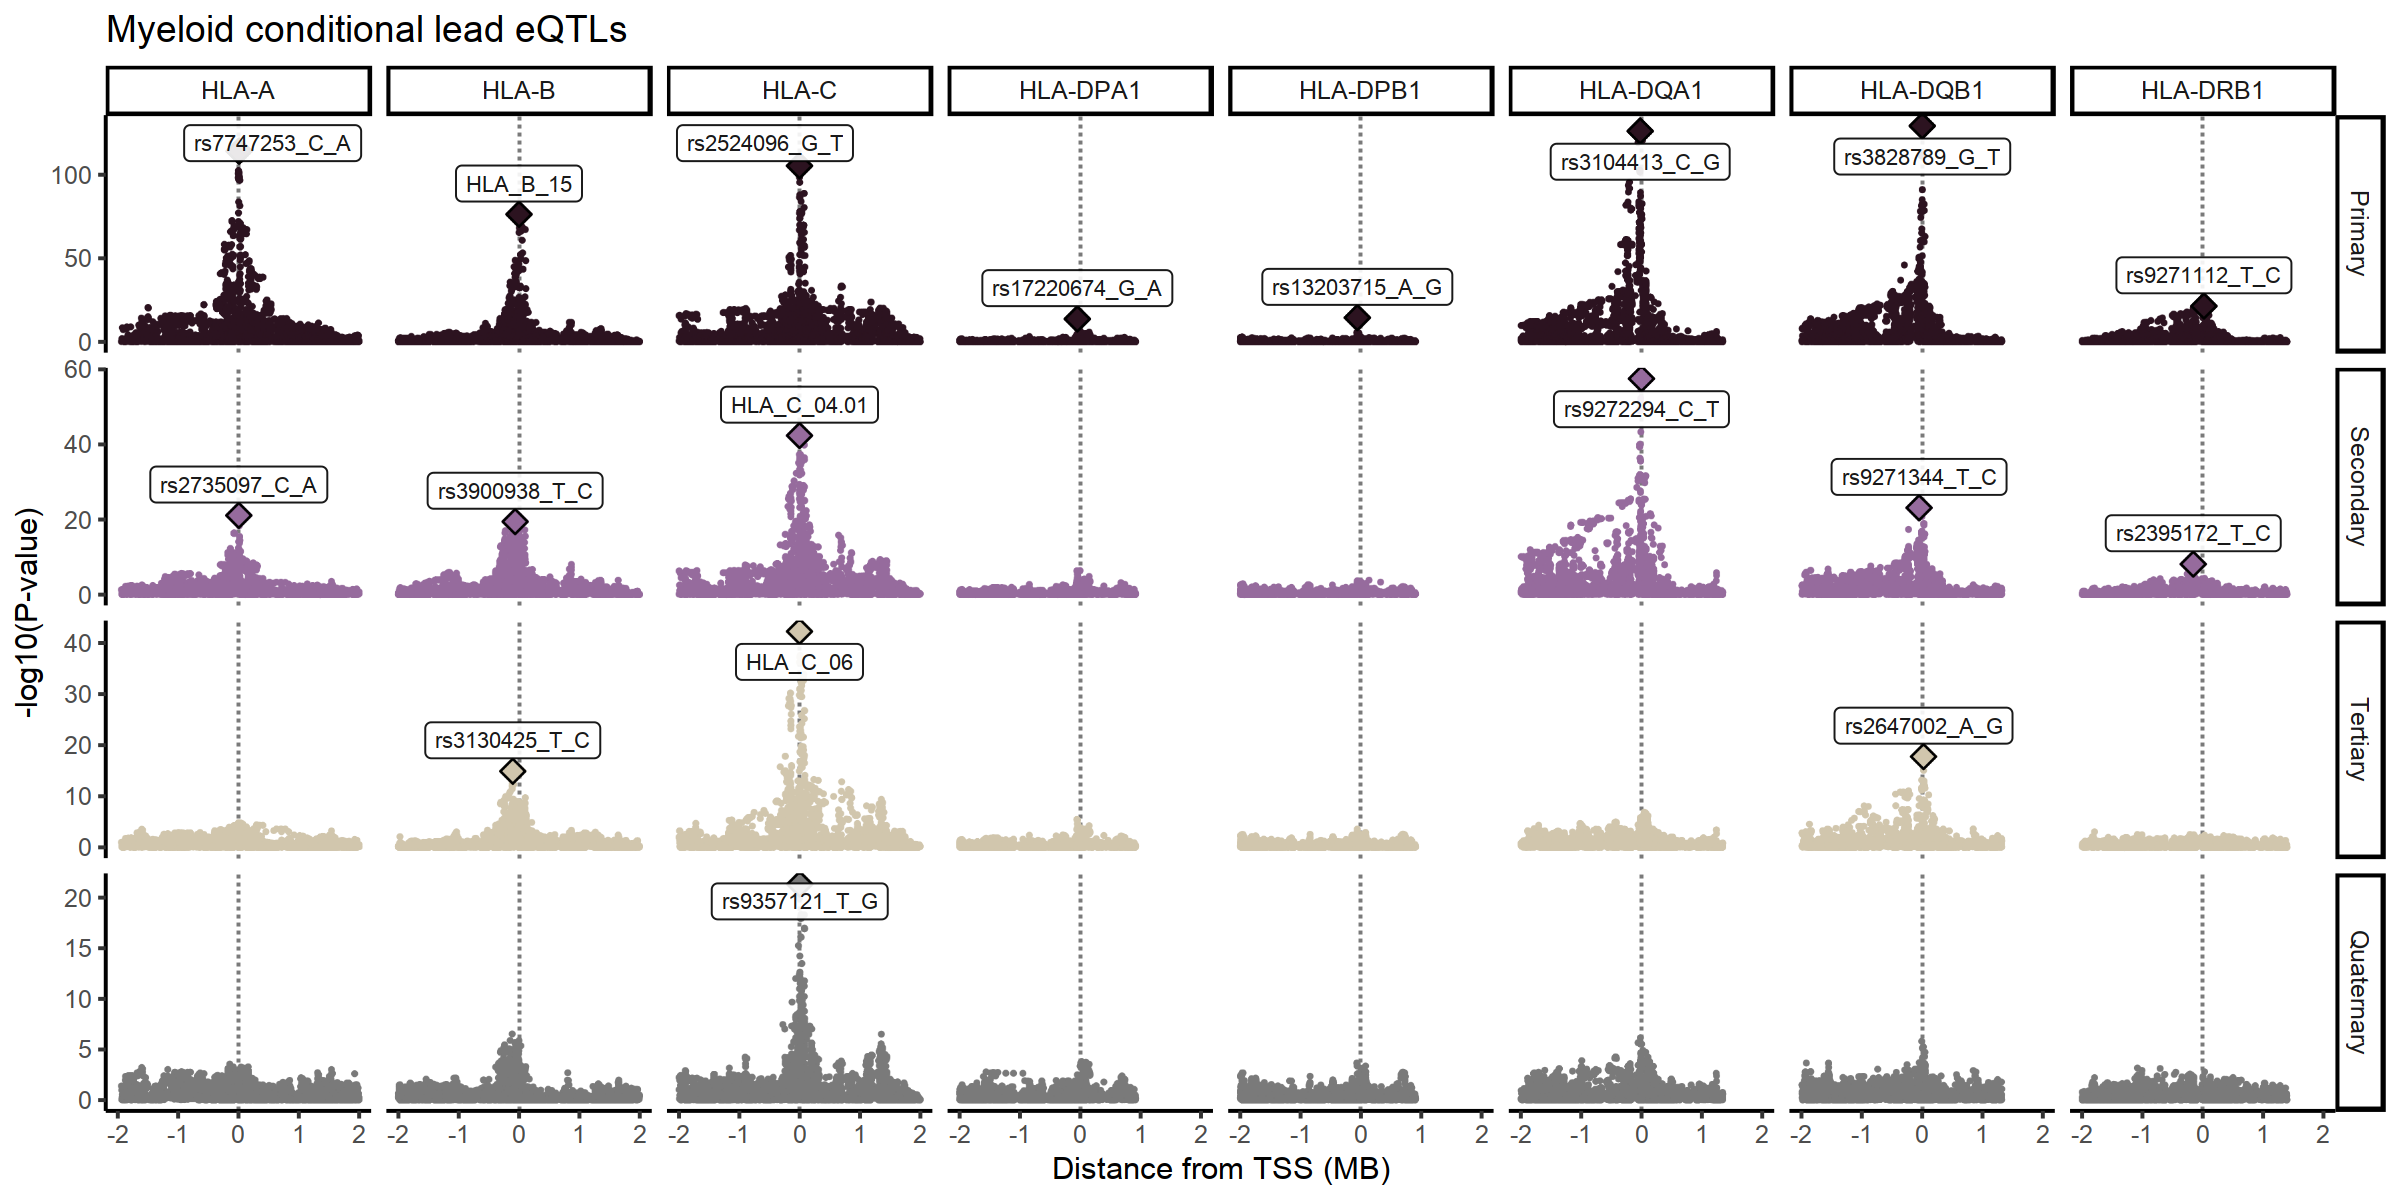

In [55]:
fig.size(6, 12)

pdf(paste0('../SuppFigs/conditional_pseudobulk_eQTLs_colorby_conditional_Myeloid.pdf'), height=6, width=12)

results$gene = str_replace(results$gene, '\\.', '-')
lead_to_label = results %>% filter(lead_status == 'Lead')
# Add newlines at 4th "_"
for (i in 1:nrow(lead_to_label)) {
    if (startsWith(lead_to_label$variant[i], 'SNPS')){
        str_vec <- strsplit(lead_to_label$variant[i], "_")[[1]] 
        where <- seq_along(str_vec) == 4
        str_vec[where] <- sub("", "\n", str_vec[where])
        lead_to_label$variant[i] = paste(str_vec, collapse="_")
    }
}

p = results %>% 
        ggplot() + geom_vline(xintercept = 0, linetype = 'dashed', col = 'grey48') +
        
        # plot all variants
        geom_point_rast(aes(x = dist_from_TSS / 1e6, y = -log10(p.val), fill = eQTL,
                            col = eQTL, size = lead_status, shape = lead_status)) +
        xlab('Distance from TSS (MB)') + scale_color_manual(values = eQTL_colors) + scale_fill_manual(values = eQTL_colors) +
        guides(fill = guide_legend(override.aes = list(size = 3))) + guides(shape = "none", size = "none") +
        
        # plot lead variant with diamond
        geom_point_rast(data = lead_to_label, aes(x = dist_from_TSS / 1e6, y = -log10(p.val), 
                            fill = eQTL, size = lead_status, shape = lead_status), col = 'black') + 
        # formatting
        ylab('-log10(P-value)') + theme_classic() + theme(legend.position = 'none') +
        facet_grid(eQTL ~ factor(gene), scales = 'free_y') +
        scale_size_manual(values = c(3, 0.6)) + scale_shape_manual(values = c(23, 20)) + 
        
        geom_label_repel(data = lead_to_label, 
                                aes(x = dist_from_TSS / 1e6, y = -log10(p.val), label = variant), size = 2.75, alpha = 0.9, nudge_y = 5) +
        ggtitle('Myeloid conditional lead eQTLs')
print(p)
dev.off()
p

In [56]:
M_lead_variants = lead_variants
M_results = results

## T

In [57]:
## Read in primary, secondary, and tertiary eQTLs
results_primary = read.csv('./4_multidataset_eQTLs/T_all_variants.csv', row.names = 1) %>% 
    mutate(gene = str_replace(gene, '-', '\\.'))
results_secondary = read.csv('./6_multidataset_conditional/T_secondary_all_variants.csv', row.names = 1)
results_tertiary = read.csv('./6_multidataset_conditional/T_tertiary_all_variants.csv', row.names = 1)
results_quaternary = read.csv('./6_multidataset_conditional/T_quaternary_all_variants.csv', row.names = 1)

results_primary$conditional_iter = 0
results = rbind.fill(results_primary, results_secondary, results_tertiary, results_quaternary)
results$cell_type = 'T'

## Add column for which iteration
results = results %>% mutate(eQTL = case_when(
                            conditional_iter == 0 ~ "Primary", 
                            conditional_iter == 1 ~ "Secondary",
                            conditional_iter == 2 ~ "Tertiary",
                            conditional_iter == 3 ~ "Quaternary"))
results$eQTL = factor(results$eQTL, levels = rev(c('Quaternary', 'Tertiary', 'Secondary', 'Primary')))
results$POS = as.numeric(results$POS)
results$hg19_POS = NULL

## Add gtf information
results = left_join(results, gtf_hla, all.x = T, all.y = F) %>% 
                        mutate(dist_from_TSS = POS - TSS) %>%
                        filter(abs(dist_from_TSS) < 2e6)

# Label REF and ALT for variants (but not HLA alleles)
results$ID = results$variant
results = results %>% mutate(
           variant = ifelse(startsWith(results$variant, 'HLA'), variant, paste(variant, REF, ALT, sep = '_')))

# Get lead variant for each cell type
results$POS = as.numeric(results$POS)
lead_variants = results %>% group_by(cell_type, gene, conditional_iter) %>% 
    slice(which.min(p.val)) %>%
    filter(p.val < 5e-8) %>% # filter to 5e-8 cutoff
    mutate(dist_from_TSS = as.numeric(POS) - TSS)

results = results %>% mutate(lead_status = case_when(
                            paste(variant, cell_type, gene, conditional_iter) %in% 
                            paste(lead_variants$variant, lead_variants$cell_type, 
                                  lead_variants$gene, lead_variants$conditional_iter) ~ "Lead",
                            TRUE ~ "none"))
table(results$lead_status)

Joining, by = "gene"



  Lead   none 
    21 265031 

png 
  2

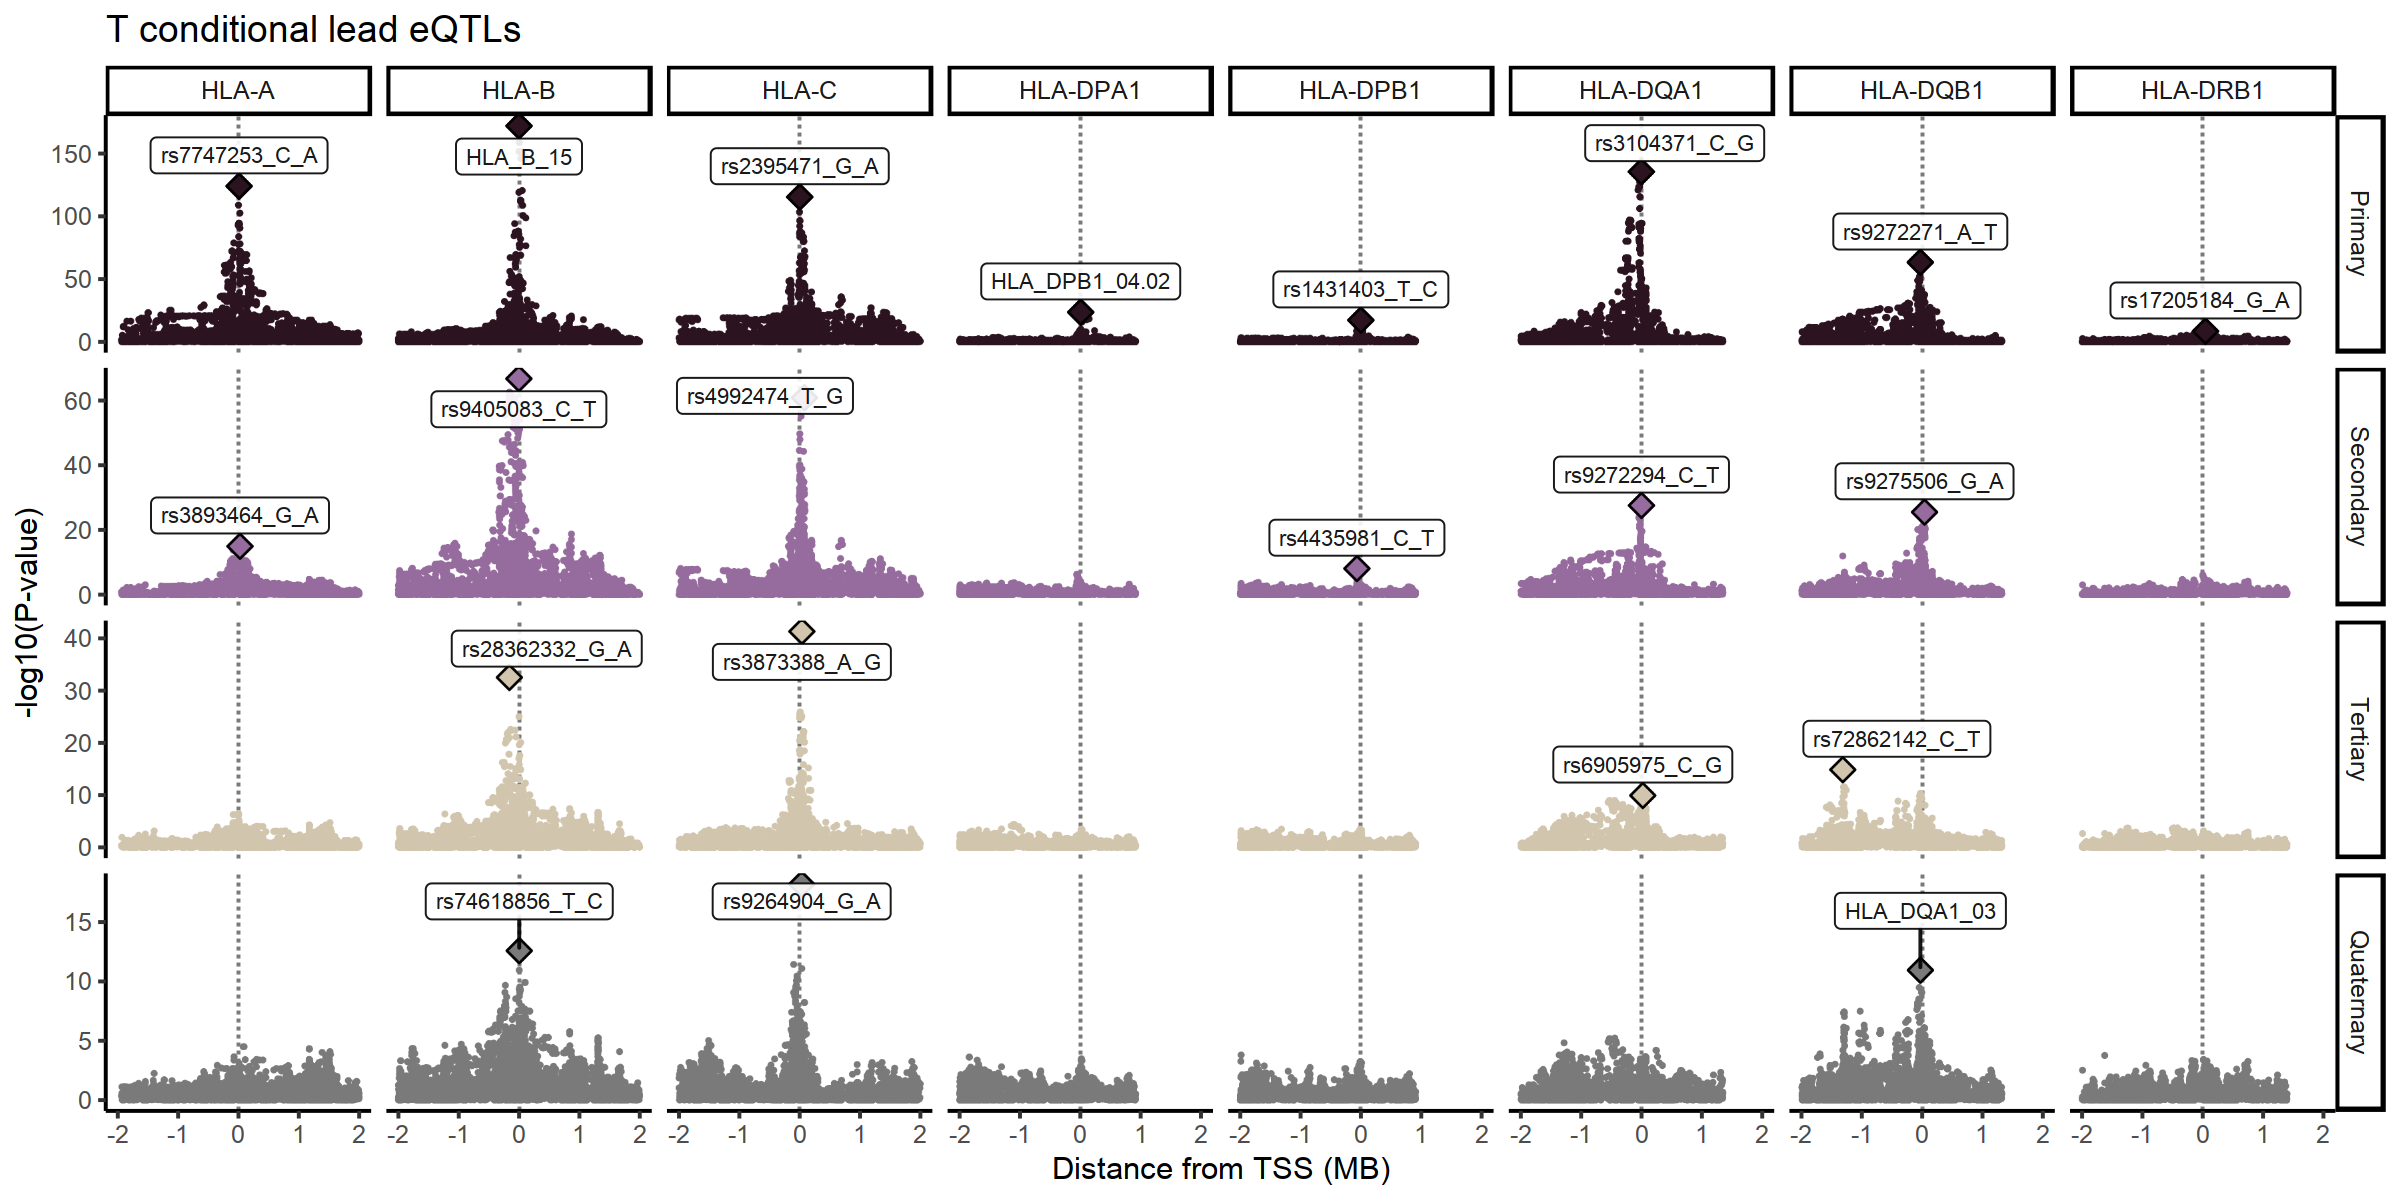

In [58]:
fig.size(6, 12)

pdf(paste0('../SuppFigs/conditional_pseudobulk_eQTLs_colorby_conditional_T.pdf'), height=6, width=12)

results$gene = str_replace(results$gene, '\\.', '-')
lead_to_label = results %>% filter(lead_status == 'Lead')
# Add newlines at 4th "_"
for (i in 1:nrow(lead_to_label)) {
    if (startsWith(lead_to_label$variant[i], 'SNPS')){
        str_vec <- strsplit(lead_to_label$variant[i], "_")[[1]] 
        where <- seq_along(str_vec) == 4
        str_vec[where] <- sub("", "\n", str_vec[where])
        lead_to_label$variant[i] = paste(str_vec, collapse="_")
    }
}

p = results %>% 
        ggplot() + geom_vline(xintercept = 0, linetype = 'dashed', col = 'grey48') +
        
        # plot all variants
        geom_point_rast(aes(x = dist_from_TSS / 1e6, y = -log10(p.val), fill = eQTL,
                            col = eQTL, size = lead_status, shape = lead_status)) +
        xlab('Distance from TSS (MB)') + scale_color_manual(values = eQTL_colors) + scale_fill_manual(values = eQTL_colors) +
        guides(fill = guide_legend(override.aes = list(size = 3))) + guides(shape = "none", size = "none") +
        
        # plot lead variant with diamond
        geom_point_rast(data = lead_to_label, aes(x = dist_from_TSS / 1e6, y = -log10(p.val), 
                            fill = eQTL, size = lead_status, shape = lead_status), col = 'black') + 
        # formatting
        ylab('-log10(P-value)') + theme_classic() + theme(legend.position = 'none') +
        facet_grid(eQTL ~ factor(gene), scales = 'free_y') +
        scale_size_manual(values = c(3, 0.6)) + scale_shape_manual(values = c(23, 20)) + 
        
        geom_label_repel(data = lead_to_label, 
                                aes(x = dist_from_TSS / 1e6, y = -log10(p.val), label = variant), size = 2.75, alpha = 0.9, nudge_y = 5) +
        ggtitle('T conditional lead eQTLs')
print(p)
dev.off()
p

In [59]:
T_lead_variants = lead_variants
T_results = results

## Write supp table

In [60]:
tab_results = rbind(B_results, M_results, T_results)
dim(tab_results)
tab_results = tab_results %>% arrange(cell_type, gene, conditional_iter, POS) %>%
    dplyr::select(ID, cell_type, gene, conditional_iter, beta, stderr, p.val) %>%
    mutate( conditional_iter = paste0(conditional_iter + 1),
            beta = round(beta, 3),
            stderr = round(stderr, 3),
            p.val = as.numeric(format(p.val, digits = 4, scientific = TRUE))) %>% filter(p.val < 0.05) # to save space
colnames(tab_results)[1] = 'variant'
head(tab_results)
write.csv(tab_results, '../SuppTables/Table_conditional_analysis.csv', quote = F, row.names = F)

[1] 795144     29

variant    cell_type gene  conditional_iter beta   stderr p.val    
1 rs4141691  B         HLA-A 1                -0.108 0.048  2.293e-02
2 rs10484402 B         HLA-A 1                 0.151 0.073  3.746e-02
3 rs72848791 B         HLA-A 1                 0.334 0.057  5.656e-09
4 rs149990   B         HLA-A 1                -0.241 0.040  2.863e-09
5 rs149943   B         HLA-A 1                -0.241 0.040  2.895e-09
6 rs202906   B         HLA-A 1                -0.244 0.040  1.027e-09

## Make table for PLINK

In [61]:
cond_lead_variants = rbind(B_lead_variants, M_lead_variants, T_lead_variants) %>% ungroup() %>% as.data.frame()

geno_df$hg19_POS = as.numeric(geno_df$hg19_POS)
cond_lead_variants$hg19_POS = NULL
cond_lead_variants = left_join(cond_lead_variants, geno_df[, c('ID', 'hg19_POS')], by = 'ID', all.y = F)
cond_lead_variants = cond_lead_variants %>% mutate(plink_list = ifelse(startsWith(ID, 'rs'), paste0(ID, ';6:', hg19_POS), ID)) %>%
                                mutate(plink_list = ifelse(startsWith(ID, 'HLA'), sub("(_.*?)_", "\\1*", ID), plink_list))

cond_lead_variants$plink_list
length(cond_lead_variants$plink_list)
cond_lead_variants$plink_list = str_replace(cond_lead_variants$plink_list, '\\.0', ':0')
write.table(unique(cond_lead_variants$plink_list), './plink_list.txt', quote = F, row.names =F, col.names = F)

[1] "rs417162;6:29916505"    "rs6457110;6:29933881"   "HLA_B*15"              
 [4] "HLA_B*35"               "rs9266266;6:31326011"   "HLA_C*07"              
 [7] "rs12208888;6:31247430"  "rs2523613;6:31320687"   "rs9265866;6:31312758"  
[10] "rs2163472;6:32983375"   "HLA_DPA1*01"            "rs435119;6:32986835"   
[13] "rs2395305;6:32985376"   "rs3091284;6:33057244"   "rs435119;6:32986835"   
[16] "HLA_DPB1*04.01"         "rs9271375;6:32587067"   "rs9275125;6:32650293"  
[19] "rs116763083;6:32569932" "rs9272346;6:32604372"   "rs1612904;6:32669018"  
[22] "rs6905837;6:32626205"   "rs9271117;6:32576795"   "rs13207945;6:32579708" 
[25] "rs7747253;6:29919779"   "rs2735097;6:29915301"   "HLA_B*15"              
[28] "rs3900938;6:31257622"   "rs3130425;6:31218327"   "rs2524096;6:31236467"  
[31] "HLA_C*04.01"            "HLA_C*06"               "rs9357121;6:31240479"  
[34] "rs17220674;6:32987644"  "rs13203715;6:32988588"  "rs3104413;6:32582650"  
[37] "rs9272294;6:32603760"   "rs3828789;6:32635754"   "rs9271344;6:32583328"  
[40] "rs2647002;6:32657082"   "rs9271112;6:32576717"   "rs2395172;6:32399842"  
[43] "rs7747253;6:29919779"   "rs3893464;6:29935250"   "HLA_B*15"              
[46] "rs9405083;6:31319489"   "rs28362332;6:31162154"  "rs74618856;6:31325745" 
[49] "rs2395471;6:31240692"   "rs4992474;6:31318933"   "rs3873388;6:31275827"  
[52] "rs9264904;6:31272553"   "HLA_DPB1*04.02"         "rs1431403;6:33047031"  
[55] "rs4435981;6:32981682"   "rs3104371;6:32602137"   "rs9272294;6:32603760"  
[58] "rs6905975;6:32626139"   "rs9272271;6:32603526"   "rs9275506;6:32674083"  
[61] "rs72862142;6:31318949"  "HLA_DQA1*03"            "rs17205184;6:32602551"

[1] 63

In terminal:

`plink -vcf ALL3.merged.4digit.4field.conv.all_QC.ref_aligned.eagle.vcf --extract ../../eqtl_pseudobulk/plink_list.txt --make-bed --out conditional_eqtls`

`plink --bfile conditional_eqtls --r2  --ld-window-kb 10000000 --ld-window 100 --ld-window-r2 0 --out conditional_eqtls`

In [62]:
length(unique(cond_lead_variants$plink_list))

[1] 58

58 (out of 63) unique signals

In [63]:
ld.res = read.table('../data/MHC_reference/conditional_eqtls.ld', header = 1)
mytab = NULL
for (i in cond_lead_variants$plink_list) {
    for (j in cond_lead_variants$plink_list) {
        mytab = rbind(mytab, cbind(i, j))
    }
}
colnames(mytab) = c('SNPA', 'SNPB')

mytab = as.data.frame(mytab)
mytab$R2 = -1

In [64]:
for (i in 1:nrow(mytab)) {
    snpa = mytab[i, 'SNPA']
    snpb = mytab[i, 'SNPB']
    if (snpa == snpb) { 
        mytab[i, 'R2'] = 1 
    } else {
        idx_ld.res = which( (ld.res$SNP_A == snpa & ld.res$SNP_B == snpb) |
                        (ld.res$SNP_B == snpa & ld.res$SNP_A == snpb))
        mytab[i, 'R2'] = ld.res[idx_ld.res, 'R2']
    }
}
nrow(ld.res)

[1] 1653

## Plot LD heatmap

In [65]:
colnames(cond_lead_variants)
cond_lead_variants = cond_lead_variants %>% 
                            mutate(key = paste(cell_type, gene, (conditional_iter+1), ID, sep = ';'))
table(cond_lead_variants$gene)
table(cond_lead_variants$cell_type)

[1] "variant"                "cell_type"              "gene"                  
 [4] "beta"                   "stderr"                 "t.val"                 
 [7] "p.val"                  "CHROM"                  "POS"                   
[10] "REF"                    "ALT"                    "DR2"                   
[13] "Imputed"                "AMP2RA_MAF"             "Smillie_MAF"           
[16] "Randolph_MAF"           "OneK1K_MAF"             "conditional_iter"      
[19] "lead_variant"           "secondary_lead_variant" "tertiary_lead_variant" 
[22] "eQTL"                   "gene_name"              "TSS"                   
[25] "width"                  "strand"                 "dist_from_TSS"         
[28] "ID"                     "hg19_POS"               "plink_list"


   HLA.A    HLA.B    HLA.C HLA.DPA1 HLA.DPB1 HLA.DQA1 HLA.DQB1 HLA.DRB1 
       6       10       12        5        7        8       10        5 


      B Myeloid       T 
     24      18      21 

In [66]:
output = NULL
# loop #1
for (i in 1:nrow(cond_lead_variants)) {
    cell_type1 = cond_lead_variants[i, 'cell_type']
    gene1 = cond_lead_variants[i, 'gene']
    round1 = cond_lead_variants[i, 'conditional_iter'] + 1
    variant1 = cond_lead_variants[i, 'plink_list']
    
    # loop #2
    for (j in 1:nrow(cond_lead_variants)) {
        cell_type2 = cond_lead_variants[j, 'cell_type']
        gene2 = cond_lead_variants[j, 'gene']
        round2 = cond_lead_variants[j, 'conditional_iter'] + 1
        variant2 = cond_lead_variants[j, 'plink_list']
        R2 = unique(mytab[which(mytab$SNPA == variant1 & mytab$SNPB == variant2), 'R2'])
        
        out = data.frame(cell_type1 = cell_type1, gene1 = gene1, round1 = round1, variant1 = variant1, 
                                         cell_type2 = cell_type2, gene2 = gene2, round2 = round2, variant2 = variant2, r2 = R2)
        output = rbind(output, out)
    }
}

In [67]:
mytab %>% arrange(-R2) %>% filter(R2 != 1) %>% head(6)
63^2

SNPA                 SNPB                 R2      
1 rs2163472;6:32983375 rs2395305;6:32985376 0.999526
2 rs2395305;6:32985376 rs2163472;6:32983375 0.999526
3 rs2163472;6:32983375 rs4435981;6:32981682 0.987796
4 rs4435981;6:32981682 rs2163472;6:32983375 0.987796
5 rs2395305;6:32985376 rs4435981;6:32981682 0.987322
6 rs4435981;6:32981682 rs2395305;6:32985376 0.987322

[1] 3969

In [68]:
out_linked = output %>% filter((paste0(cell_type1, gene1, round1) != 
                   paste0(cell_type2, gene2, round2))) %>% # don't count the exact same SNP as being duplicated
            filter(r2 > 0.8) %>%
            arrange(-r2)
out_linked

cell_type1 gene1    round1 variant1             cell_type2 gene2    round2
1  B          HLA.B    1      HLA_B*15             Myeloid    HLA.B    1     
2  B          HLA.B    1      HLA_B*15             T          HLA.B    1     
3  B          HLA.DPA1 3      rs435119;6:32986835  B          HLA.DPB1 3     
4  B          HLA.DPB1 3      rs435119;6:32986835  B          HLA.DPA1 3     
5  Myeloid    HLA.A    1      rs7747253;6:29919779 T          HLA.A    1     
6  Myeloid    HLA.B    1      HLA_B*15             B          HLA.B    1     
7  Myeloid    HLA.B    1      HLA_B*15             T          HLA.B    1     
8  Myeloid    HLA.DQA1 2      rs9272294;6:32603760 T          HLA.DQA1 2     
9  T          HLA.A    1      rs7747253;6:29919779 Myeloid    HLA.A    1     
10 T          HLA.B    1      HLA_B*15             B          HLA.B    1     
11 T          HLA.B    1      HLA_B*15             Myeloid    HLA.B    1     
12 T          HLA.DQA1 2      rs9272294;6:32603760 Myeloid    HLA.DQA1 2     
13 B          HLA.DPA1 1      rs2163472;6:32983375 B          HLA.DPB1 1     
14 B          HLA.DPB1 1      rs2395305;6:32985376 B          HLA.DPA1 1     
15 B          HLA.DPA1 1      rs2163472;6:32983375 T          HLA.DPB1 2     
16 T          HLA.DPB1 2      rs4435981;6:32981682 B          HLA.DPA1 1     
17 B          HLA.DPB1 1      rs2395305;6:32985376 T          HLA.DPB1 2     
18 T          HLA.DPB1 2      rs4435981;6:32981682 B          HLA.DPB1 1     
19 B          HLA.DQB1 1      rs9272346;6:32604372 Myeloid    HLA.DQB1 1     
20 Myeloid    HLA.DQB1 1      rs3828789;6:32635754 B          HLA.DQB1 1     
21 T          HLA.DQA1 1      rs3104371;6:32602137 T          HLA.DQB1 4     
22 T          HLA.DQB1 4      HLA_DQA1*03          T          HLA.DQA1 1     
23 B          HLA.DRB1 1      rs9271117;6:32576795 Myeloid    HLA.DRB1 1     
24 Myeloid    HLA.DRB1 1      rs9271112;6:32576717 B          HLA.DRB1 1     
25 Myeloid    HLA.DQA1 1      rs3104413;6:32582650 T          HLA.DQA1 1     
26 T          HLA.DQA1 1      rs3104371;6:32602137 Myeloid    HLA.DQA1 1     
27 Myeloid    HLA.DQA1 1      rs3104413;6:32582650 T          HLA.DQB1 4     
28 T          HLA.DQB1 4      HLA_DQA1*03          Myeloid    HLA.DQA1 1     
   variant2             r2      
1  HLA_B*15             1.000000
2  HLA_B*15             1.000000
3  rs435119;6:32986835  1.000000
4  rs435119;6:32986835  1.000000
5  rs7747253;6:29919779 1.000000
6  HLA_B*15             1.000000
7  HLA_B*15             1.000000
8  rs9272294;6:32603760 1.000000
9  rs7747253;6:29919779 1.000000
10 HLA_B*15             1.000000
11 HLA_B*15             1.000000
12 rs9272294;6:32603760 1.000000
13 rs2395305;6:32985376 0.999526
14 rs2163472;6:32983375 0.999526
15 rs4435981;6:32981682 0.987796
16 rs2163472;6:32983375 0.987796
17 rs4435981;6:32981682 0.987322
18 rs2395305;6:32985376 0.987322
19 rs3828789;6:32635754 0.976990
20 rs9272346;6:32604372 0.976990
21 HLA_DQA1*03          0.974602
22 rs3104371;6:32602137 0.974602
23 rs9271112;6:32576717 0.967139
24 rs9271117;6:32576795 0.967139
25 rs3104371;6:32602137 0.860453
26 rs3104413;6:32582650 0.860453
27 HLA_DQA1*03          0.845443
28 rs3104413;6:32582650 0.845443

In [69]:
sum(!cond_lead_variants$plink_list %in% out_linked$variant1)

[1] 44

In [70]:
44/58

[1] 0.7586207

png 
  2

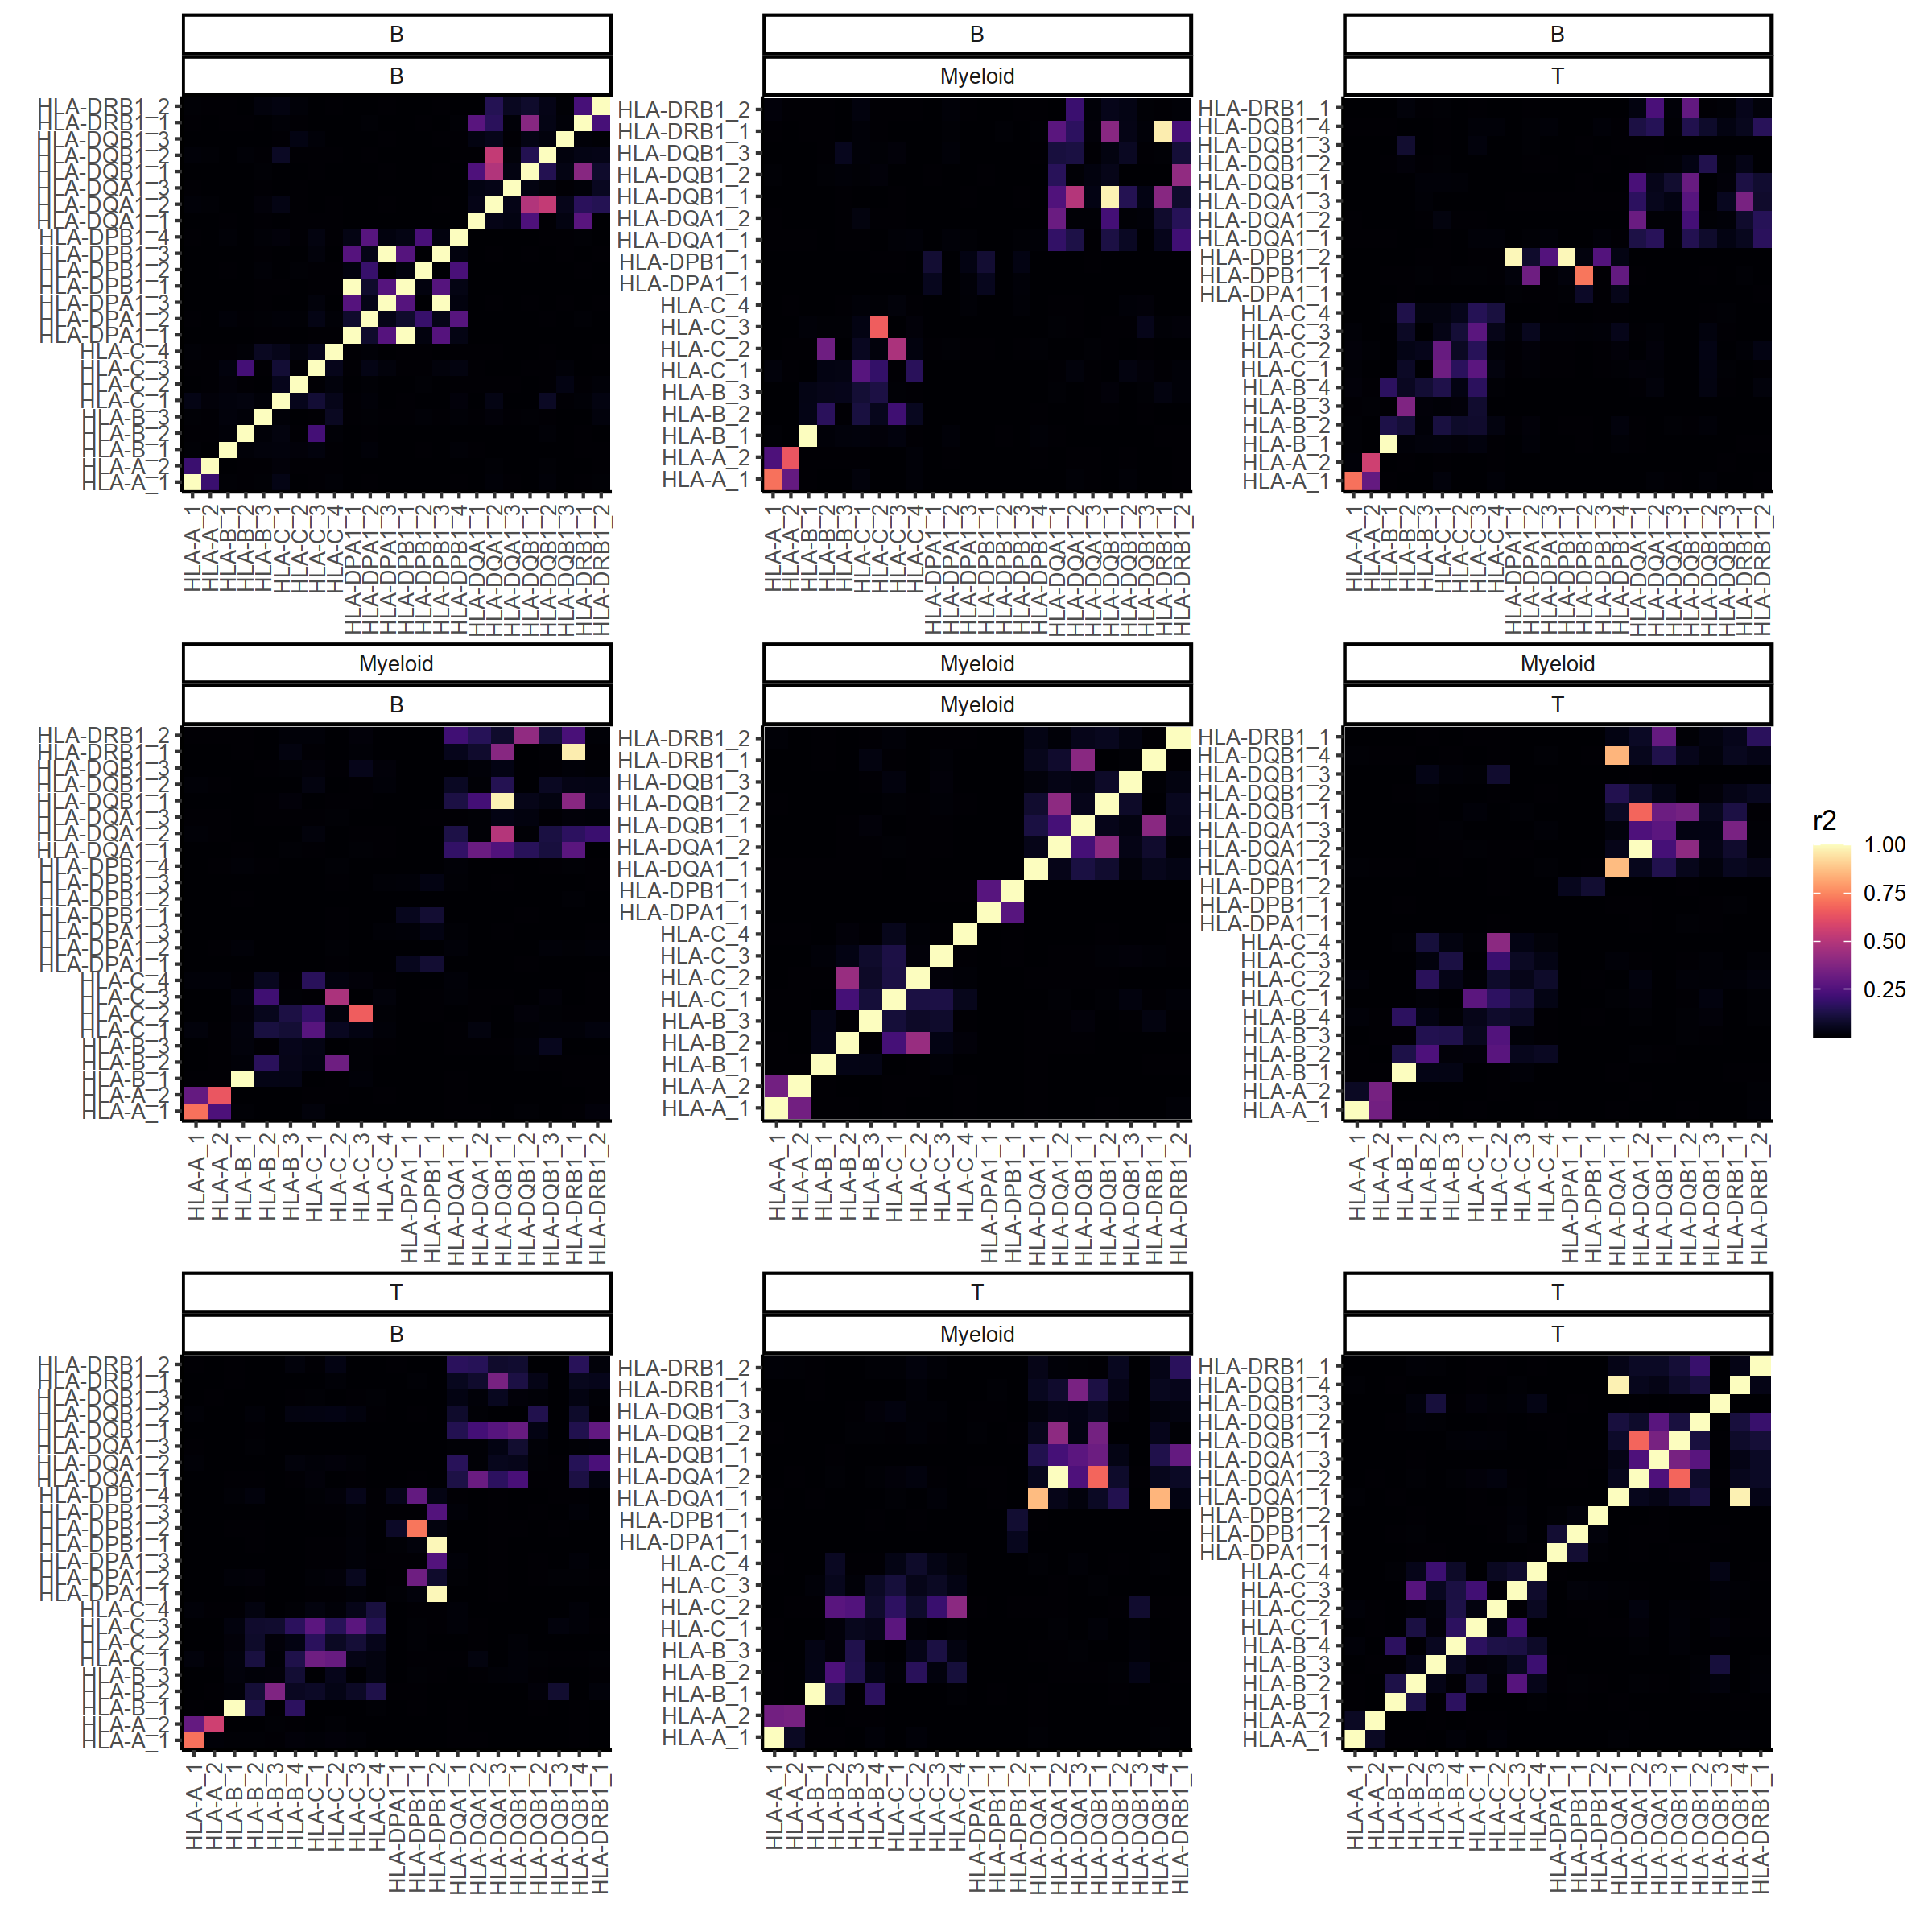

In [74]:
fig.size(12, 12)
pdf(paste0('../SuppFigs/conditional_heatmap.pdf'), width = 12, height = 12)
p = output %>% ggplot() +
    geom_tile(aes(x = paste(str_replace(gene1, '\\.', '-'), round1, sep = '_'), 
                  y = paste(str_replace(gene2, '\\.', '-'), round2, sep = '_'), fill = r2)) +
    theme_classic(base_size = 12) +
    facet_wrap( ~ cell_type1 + cell_type2, scales = 'free') + scale_fill_viridis(option = 'magma') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(strip.placement = "outside") +
    xlab('') + ylab('')
print(p)
dev.off()
p

LD between rs9272294 and rs3104413

In [72]:
output %>% filter(startsWith(variant1, 'rs3104371'), startsWith(variant2, 'rs3104413'))

cell_type1 gene1    round1 variant1             cell_type2 gene2    round2
1 T          HLA.DQA1 1      rs3104371;6:32602137 Myeloid    HLA.DQA1 1     
  variant2             r2      
1 rs3104413;6:32582650 0.860453

In [73]:
output %>% filter(startsWith(variant1, 'rs9272294'), startsWith(variant2, 'rs3104413'))

cell_type1 gene1    round1 variant1             cell_type2 gene2    round2
1 Myeloid    HLA.DQA1 2      rs9272294;6:32603760 Myeloid    HLA.DQA1 1     
2 T          HLA.DQA1 2      rs9272294;6:32603760 Myeloid    HLA.DQA1 1     
  variant2             r2       
1 rs3104413;6:32582650 0.0422572
2 rs3104413;6:32582650 0.0422572

# Compare results to Aguiar et al. 2019

[1] 0.7693091

png 
  2

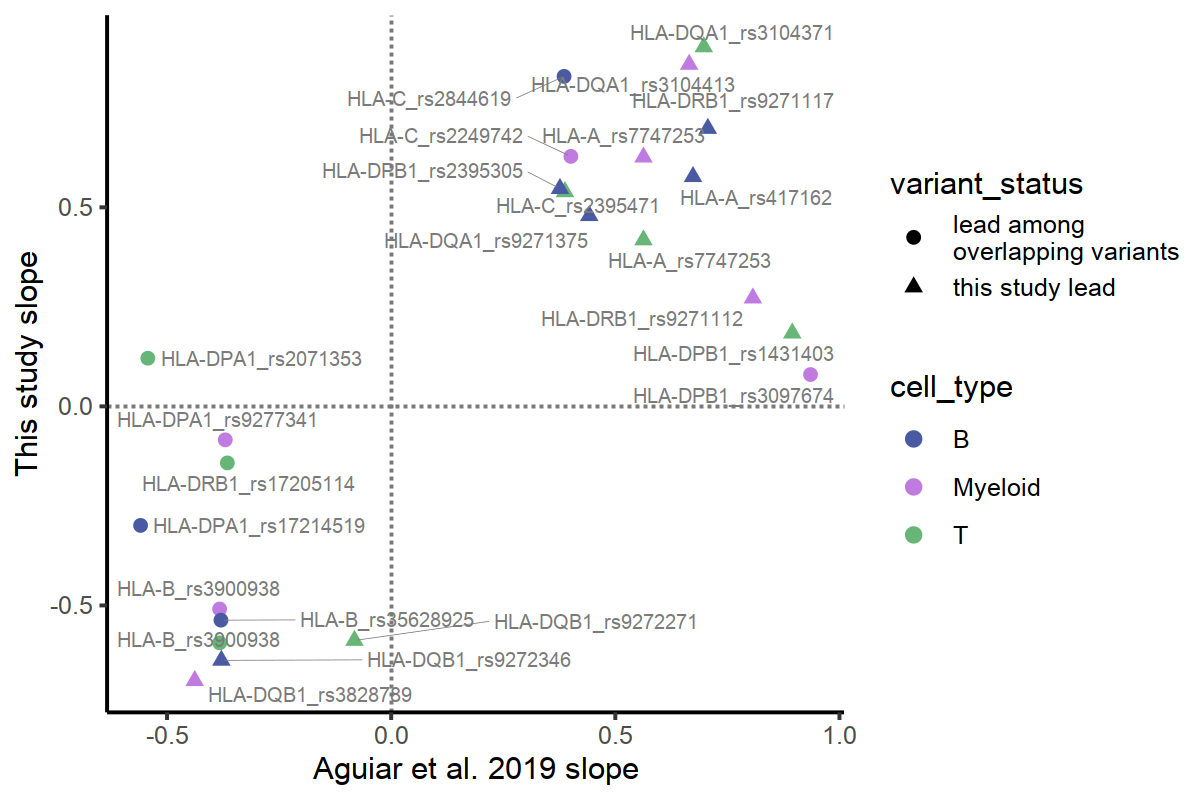

In [46]:
prefix = './4_multidataset_eQTLs/'

# Multi dataset lead variants - Pers
B_plasma_results = read.csv(paste0(prefix, 'B_plasma_all_variants.csv'), row.names = 1)
Myeloid_results = read.csv(paste0(prefix, 'Myeloid_all_variants.csv'), row.names = 1)
T_results = read.csv(paste0(prefix, 'T_all_variants.csv'), row.names = 1) %>% mutate(cell_type = 'T')
multi_dataset_result = rbind(B_plasma_results, Myeloid_results, T_results) %>%
    dplyr::select('variant', 'cell_type', 'gene', 'beta', 'p.val', 'POS', 'REF', 'ALT')

# Aguiar et al. Plos Genetics 2019 result
aguiar = read.delim('../data/Aguiar_2019/hlaqtls.tsv')

# Restrict results to the lead variant that was also tested in Aguiar et al.
intersecting_idx = which(
    paste0(multi_dataset_result$gene, multi_dataset_result$variant, multi_dataset_result$REF, multi_dataset_result$ALT) %in% 
    paste0(aguiar$gene, aguiar$variant_id, aguiar$ref, aguiar$alt))
multi_dataset_result = multi_dataset_result[intersecting_idx,]
multi_dataset_result = multi_dataset_result %>%
    group_by(cell_type, gene) %>% slice(which.min(p.val))

aguiar$gene_variant = paste(aguiar$gene, aguiar$variant_id, aguiar$ref, aguiar$alt, sep = '_')
multi_dataset_result = multi_dataset_result %>% 
        mutate(gene_variant = paste(str_replace(gene, '\\.', '-'), variant, REF, ALT, sep = '_'))

a = right_join(aguiar, multi_dataset_result, by = 'gene_variant')

# Color by whether this was our lead variant or the next best variant matching Aguiar et al.
# Multi dataset lead variants - Pers
prefix = './4_multidataset_eQTLs/'
B_plasma_results = read.csv(paste0(prefix, 'B_plasma_lead_variants.csv'), row.names = 1)
Myeloid_results = read.csv(paste0(prefix, 'Myeloid_lead_variants.csv'), row.names = 1)
T_results = read.csv(paste0(prefix, 'T_lead_variants.csv'), row.names = 1) %>% mutate(cell_type = 'T')
multi_dataset_result = rbind(B_plasma_results, Myeloid_results, T_results) %>%
    dplyr::select('variant', 'cell_type', 'gene', 'beta', 'p.val', 'POS', 'REF', 'ALT')
multi_dataset_result = multi_dataset_result %>% 
        mutate(gene_variant = paste(str_replace(gene, '\\.', '-'), variant, REF, ALT, sep = '_'))

a$variant_status = ifelse(a$gene_variant %in% multi_dataset_result$gene_variant, 'this study lead', 'lead among\noverlapping variants')
cor(a$slope, a$beta)

fig.size(4, 6)
pdf(paste0('../SuppFigs/compare_Aguiar_direction.pdf'), height=4, width=6)
set.seed(1)
p = ggplot(a) +
    geom_point(aes(x = slope, y = beta, col = cell_type, shape = variant_status), size = 2) + theme_classic() +
    geom_hline(yintercept = 0, linetype = 'dashed', col = 'grey48') +
    geom_vline(xintercept = 0, linetype = 'dashed', col = 'grey48') +
    geom_text_repel(aes(x = slope, y = beta, label = paste(gene.x, variant, sep = '_')), 
                    size = 2.5, col = 'grey48', segment.size = 0.1) +
    scale_color_manual(values = c('#495aa3', '#bf7be0', '#67b577')) +
    xlab('Aguiar et al. 2019 slope') + ylab('This study slope')
print(p)
dev.off()
p

Restrict to B/plasma

[1] 0.9228951

png 
  2

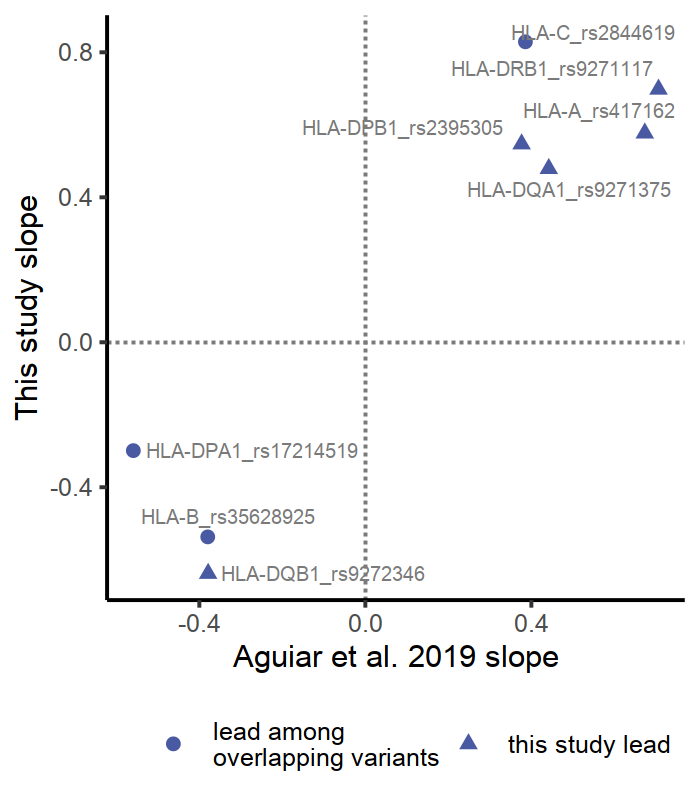

In [47]:
b = a %>% filter(cell_type == 'B') 
cor(b$slope, b$beta)

fig.size(4, 3.5)
pdf(paste0('../SuppFigs/compare_Aguiar_direction_B_plasma.pdf'), height=4, width=3.5)
set.seed(1)
p = b %>%
    ggplot() +
    geom_point(aes(x = slope, y = beta, shape = variant_status), size = 2, col = '#495aa3') + theme_classic() +
    geom_hline(yintercept = 0, linetype = 'dashed', col = 'grey48') +
    geom_vline(xintercept = 0, linetype = 'dashed', col = 'grey48') +
    geom_text_repel(aes(x = slope, y = beta, label = paste(gene.x, variant, sep = '_')), size = 2.5, col = 'grey48') +
    xlab('Aguiar et al. 2019 slope') + ylab('This study slope') + labs(shape = '') + theme(legend.position = 'bottom')
print(p)
dev.off()
p

In [48]:
B_plasma_results = read.csv(paste0(prefix, 'B_plasma_all_variants.csv'), row.names = 1)
Myeloid_results = read.csv(paste0(prefix, 'Myeloid_all_variants.csv'), row.names = 1)
T_results = read.csv(paste0(prefix, 'T_all_variants.csv'), row.names = 1) %>% mutate(cell_type = 'T')
multi_dataset_result = rbind(B_plasma_results, Myeloid_results, T_results) %>%
    dplyr::select('variant', 'cell_type', 'gene', 'beta', 'p.val', 'POS', 'REF', 'ALT') %>%
    mutate(gene_variant = paste(str_replace(gene, '\\.', '-'), variant, REF, ALT, sep = '_'))

In [49]:
head(aguiar$gene_variant)
head(multi_dataset_result$gene_variant)
pos_19 = geno_df[, c('ID', 'hg19_POS')] %>% mutate(variant = ID)

aguiar_leads = aguiar %>% filter(gene_variant %in% multi_dataset_result$gene_variant) %>% 
           group_by(gene) %>% mutate(variant = variant_id) %>%
           slice(which.max(log10pval)) %>% left_join(pos_19)

our_leads = multi_dataset_result %>% filter(cell_type == 'B') %>%
    group_by(gene) %>% slice(which.min(p.val)) %>% left_join(pos_19)

aguiar_leads$query = paste0(aguiar_leads$variant, ';6:', aguiar_leads$hg19_POS)
our_leads$query = paste0(our_leads$variant, ';6:', our_leads$hg19_POS)
cbind(aguiar_leads$query, our_leads$query)

[1] "HLA-A_rs9257794_C_T" "HLA-A_rs4713211_G_A" "HLA-A_rs3930883_G_T"
[4] "HLA-A_rs1555244_C_T" "HLA-A_rs9257795_T_G" "HLA-A_rs6934993_A_G"

[1] "HLA-A_rs149946_G_T"   "HLA-A_rs9380032_G_T"  "HLA-A_rs4141691_A_G" 
[4] "HLA-A_rs10484402_A_G" "HLA-A_rs9368540_G_A"  "HLA-A_rs17765055_T_C"

Joining, by = "variant"
Joining, by = "variant"


[,1]                  [,2]                
[1,] rs3823342;6:29913067  rs417162;6:29916505 
[2,] rs1265080;6:31112075  HLA_B_15;6:31321663 
[3,] rs5010528;6:31241032  HLA_C_07;6:31236551 
[4,] rs2301220;6:33038766  rs2163472;6:32983375
[5,] rs9277538;6:33055047  rs2395305;6:32985376
[6,] rs28366314;6:32561201 rs9271375;6:32587067
[7,] rs2647025;6:32635949  rs9272346;6:32604372
[8,] rs9270587;6:32561305  rs9271117;6:32576795

--ld rs3823342;6:29913067 rs417162;6:29916505:

   R-sq = 0.550421       D' = 0.955301

--ld rs5010528;6:31241032 HLA_C*07:

   R-sq = 0.0540222      D' = 0.996802

# Comparing eQTL results between scHLApers vs. standard pipeline
How do the eQTL betas and p-values change between scHLApers and standard pipeline?

## Plotting function (altered from above)

In [2]:
# Data is the residuals
# Result is the eQTL result (includes beta and P-value)
eqtl_boxplot_dataset = function(variant, gene, data, result, legend = FALSE, noPers = FALSE) {
    
    # Estimate the dataset effects to regress out
    colnames(data) = str_replace(colnames(data), 'HLA-', 'HLA\\.') # avoid using '-' character in lm call
    genedot = str_replace(gene, 'HLA-', 'HLA\\.')
    data$dataset = factor(data$dataset, levels = c('Randolph_NI', 'AMP2RA', 'OneK1K', 'Smillie')) # refactor to match model script
    mod = lm(as.formula(paste(genedot, ' ~ dataset + ', paste(variant, collapse = "+"), sep = "")), data = data)
    
    # Residualize out dataset effects
    data[which(data$dataset == 'Smillie'), genedot] = data[which(data$dataset == 'Smillie'), genedot] - 
                                                           summary(mod)$coeff['datasetSmillie', 'Estimate']
    data[which(data$dataset == 'AMP2RA'), genedot] = data[which(data$dataset == 'AMP2RA'), genedot] - 
                                                           summary(mod)$coeff['datasetAMP2RA', 'Estimate']
    data[which(data$dataset == 'OneK1K'), genedot] = data[which(data$dataset == 'OneK1K'), genedot] - 
                                                           summary(mod)$coeff['datasetOneK1K', 'Estimate']
    
    data$dataset = revalue(data$dataset, old_new_dataset_names)
    data$dataset = factor(data$dataset, levels = c('Synovium', 'Intestine', 'PBMC-cultured', 'PBMC-blood'))
    colnames(data) = str_replace(colnames(data), 'HLA\\.', 'HLA-') # add back '-' character in gene name
    
    # Plot the eQTL
    data[, variant] = as.factor(data[, variant])
    if (noPers) {
        pval = result[which(result$variant == variant & result$gene == gene), 'p.val_noPers'] %>% unlist()
        beta = result[which(result$variant == variant & result$gene == gene), 'beta_noPers'] %>% unlist()
    } else {
        pval = result[which(result$variant == variant & result$gene == gene), 'p.val_pers'] %>% unlist()
        beta = result[which(result$variant == variant & result$gene == gene), 'beta_pers'] %>% unlist()
    }
    subtitle = paste0('p = ', format(pval, digits = 3, scientific = TRUE),'; beta = ', format(beta, digits = 2))
    
    # Get REF/ALT alleles
    myREF = geno_df[which(geno_df$ID == variant), 'REF']
    myALT = geno_df[which(geno_df$ID == variant), 'ALT']
    data[, variant] = plyr::mapvalues(data[, variant], c(0, 1, 2), 
                            c(paste0(myREF, '/', myREF), paste0(myREF, '/', myALT), paste0(myALT, '/', myALT)), warn_missing = TRUE)
    
    p = ggplot(data) +
        geom_boxplot(aes(x = get(variant), y = get(gene), fill = dataset, col = dataset), outlier.size = 0.2) +
        geom_point_rast(aes(x = get(variant), y = get(gene), fill = dataset), 
                        size = 0.2, alpha = 0.4, position = position_jitterdodge()) +
        theme_classic() + ylab(paste(gene, 'residual')) + xlab(variant) +
        labs(subtitle = subtitle) + theme(plot.subtitle=element_text(color = "grey48")) + 
        scale_color_manual(values = cohort_colors_darker) + scale_fill_manual(values = cohort_colors)
    
    if (legend == FALSE) { p = p + theme(legend.position = 'none') }
    return(p)
}

In [3]:
# Multi dataset results - Pers
B_plasma_results = read.csv('4_multidataset_eQTLs/B_plasma_pseudobulk_eQTLs.csv') %>% mutate(cell_type = 'B')
Myeloid_results = read.csv('4_multidataset_eQTLs/Myeloid_pseudobulk_eQTLs.csv')
T_results = read.csv('4_multidataset_eQTLs/T_pseudobulk_eQTLs.csv') %>% mutate(cell_type = 'T')
combined_result_pers = rbind(B_plasma_results, Myeloid_results, T_results)

# Multi dataset results - NoPers
B_plasma_results_noPers = read.csv('4_multidataset_eQTLs/B_plasma_pseudobulk_eQTLs_noPers.csv') %>% mutate(cell_type = 'B')
Myeloid_results_noPers = read.csv('4_multidataset_eQTLs/Myeloid_pseudobulk_eQTLs_noPers.csv')
T_results_noPers = read.csv('4_multidataset_eQTLs/T_pseudobulk_eQTLs_noPers.csv') %>% mutate(cell_type = 'T')
combined_result_noPers = rbind(B_plasma_results_noPers, Myeloid_results_noPers, T_results_noPers)

combined_result_pers = combined_result_pers %>% mutate(beta_pers = beta, stderr_pers = stderr, t.val_pers = t.val, p.val_pers = p.val)
combined_result_noPers = combined_result_noPers %>% mutate(beta_noPers = beta, stderr_noPers = stderr, t.val_noPers = t.val, p.val_noPers = p.val)
combined_result = cbind(combined_result_pers, combined_result_noPers[,c('beta_noPers','t.val_noPers','p.val_noPers')]) %>%
    mutate(gene = str_replace(gene, '\\.', '-'))

png 
  2

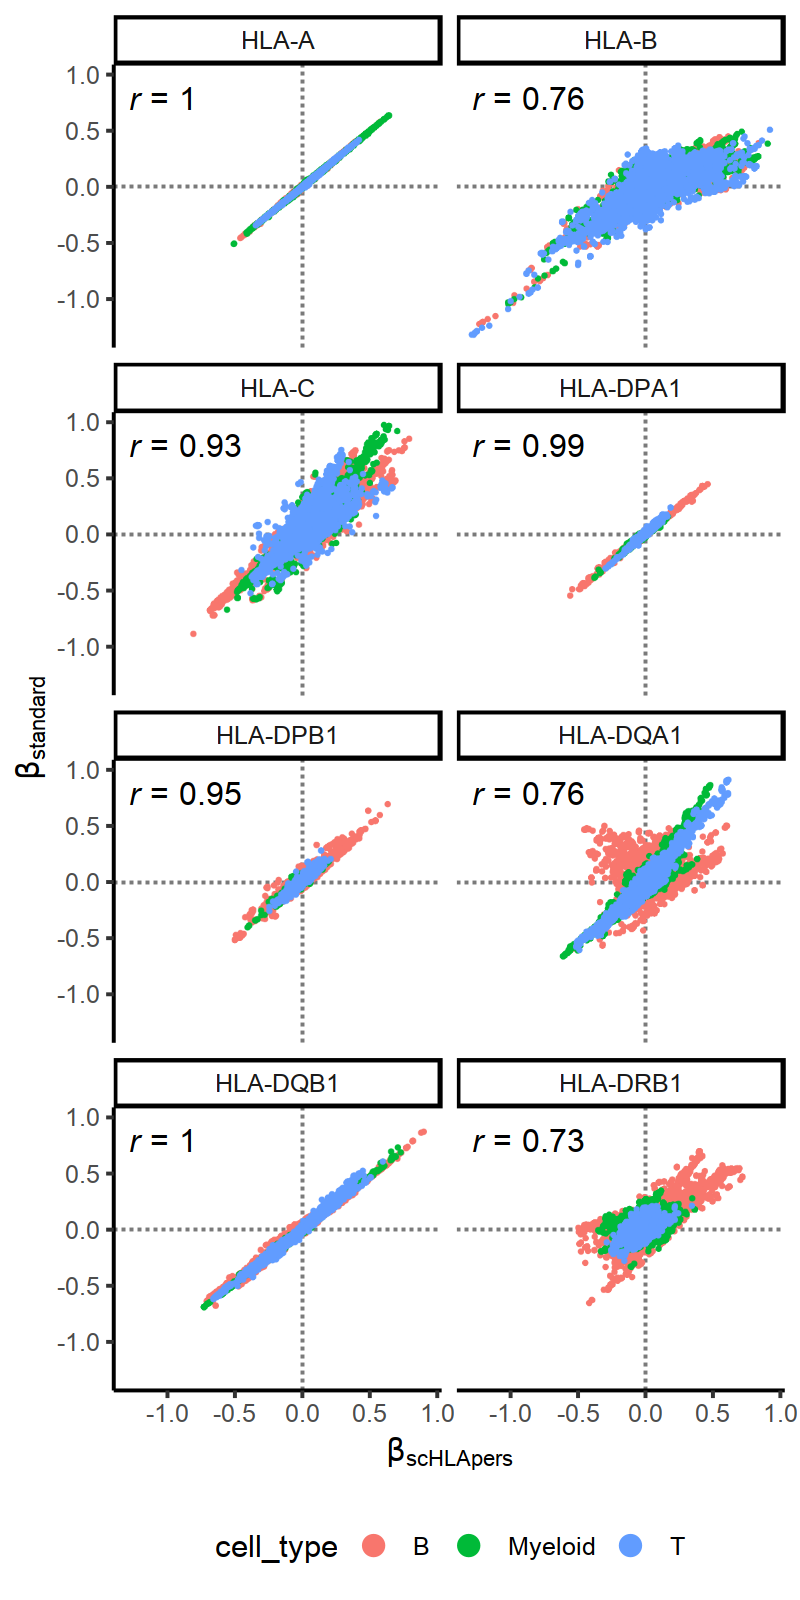

In [4]:
fig.size(8, 4)
pdf(paste0('../SuppFigs/compare_betas_diagonal.pdf'), width = 4, height = 8)
p = combined_result %>% 
    #filter(gene %in% c('HLA-B', 'HLA-C', 'HLA-DPA1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1')) %>%
    ggplot() + theme_classic() + 
    geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey48') +
    geom_vline(xintercept = 0, linetype = 'dashed', color = 'grey48') +
    geom_point_rast(aes(y = beta_pers, x = beta_noPers, col = cell_type), size = 0.2) + 
    guides(colour = guide_legend(override.aes = list(size = 3))) +
    facet_wrap(~gene, ncol = 2) + 
    stat_cor(aes(y = beta_pers, x = beta_noPers, label = ..r.label..), cor.coef.name = 'r',
            size = 4, r.accuracy = 0.01) + theme(legend.position = 'bottom') +
    xlab(expression(beta[scHLApers])) + ylab(expression(beta[standard]))
print(p)
dev.off()
p

In [5]:
variant_info = readRDS('../data/sampleXdosage/four_cohorts_variant_info_final.rds')
combined_result = cbind(combined_result, variant_info)
combined_result %>% head(4)

X variant    cell_type gene  beta        stderr     t.val      p.val     
1 1 rs149946   B         HLA-A -0.02854823 0.03209148 -0.8895892 0.37388757
2 2 rs9380032  B         HLA-A  0.04313633 0.09385237  0.4596190 0.64588362
3 3 rs4141691  B         HLA-A -0.10833946 0.04756064 -2.2779229 0.02292881
4 4 rs10484402 B         HLA-A  0.15135775 0.07265155  2.0833381 0.03745868
  beta_pers   stderr_pers ⋯ ID         REF ALT DR2  Imputed AMP2RA_MAF
1 -0.02854823 0.03209148  ⋯ rs149946   G   T   0.98 IMP     0.22463768
2  0.04313633 0.09385237  ⋯ rs9380032  G   T   0.95 IMP     0.02898551
3 -0.10833946 0.04756064  ⋯ rs4141691  A   G   0.92 IMP     0.06521739
4  0.15135775 0.07265155  ⋯ rs10484402 A   G   0.91 IMP     0.05797101
  Smillie_MAF Randolph_MAF OneK1K_MAF hg19_POS
1 0.22477273  0.36301370   0.22882288 27970031
2 0.02272727  0.02054795   0.02090209 27976200
3 0.14386364  0.18493151   0.09295930 27979188
4 0.02340909  0.03424658   0.03300330 27979625

## HLA-DRB1 in B cells

In [6]:
combined_result$beta_difference = abs(combined_result$beta_pers - combined_result$beta_noPers)
combined_result %>%
    filter(gene == 'HLA-DRB1' & cell_type == 'B') %>% arrange(-abs(beta_difference)) %>% head(4) %>%
    dplyr::select(variant, cell_type, gene, beta_pers, beta_noPers, p.val_pers, p.val_noPers, beta_difference)

variant        cell_type gene     beta_pers   beta_noPers p.val_pers
1 HLA_DRB1_07.01 B         HLA-DRB1 0.016199478 -0.4974828  0.7252875 
2 HLA_DRB1_07    B         HLA-DRB1 0.009557582 -0.4884868  0.8315831 
3 rs28366321     B         HLA-DRB1 0.041871069 -0.4538766  0.3284070 
4 rs17202787     B         HLA-DRB1 0.036164729 -0.4550467  0.5367893 
  p.val_noPers beta_difference
1 3.433809e-26 0.5136823      
2 1.439203e-26 0.4980443      
3 3.034922e-25 0.4957477      
4 5.205653e-14 0.4912114

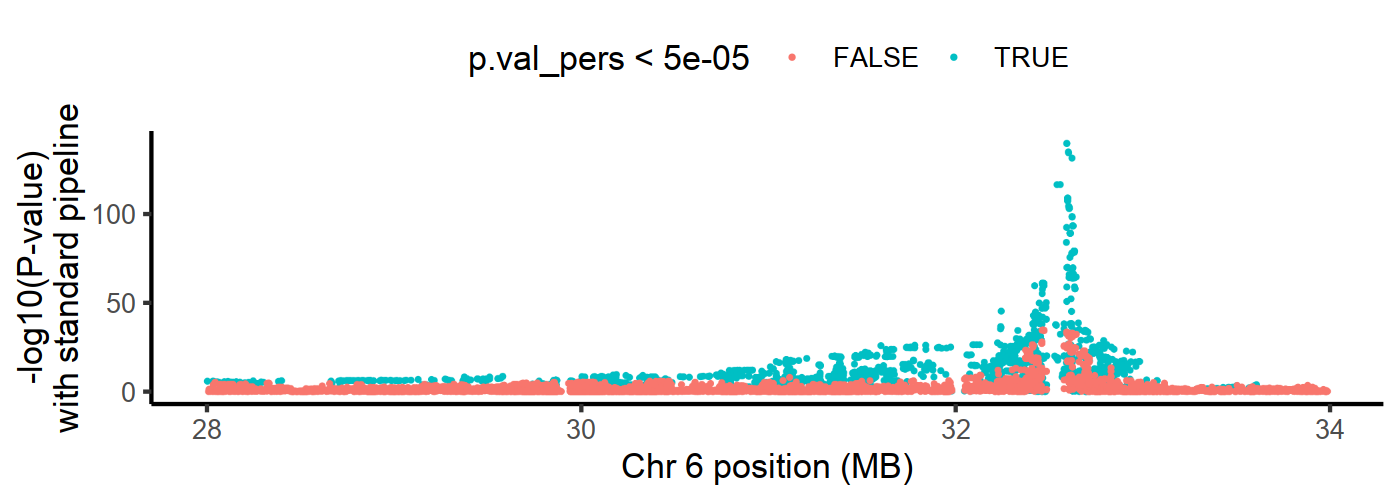

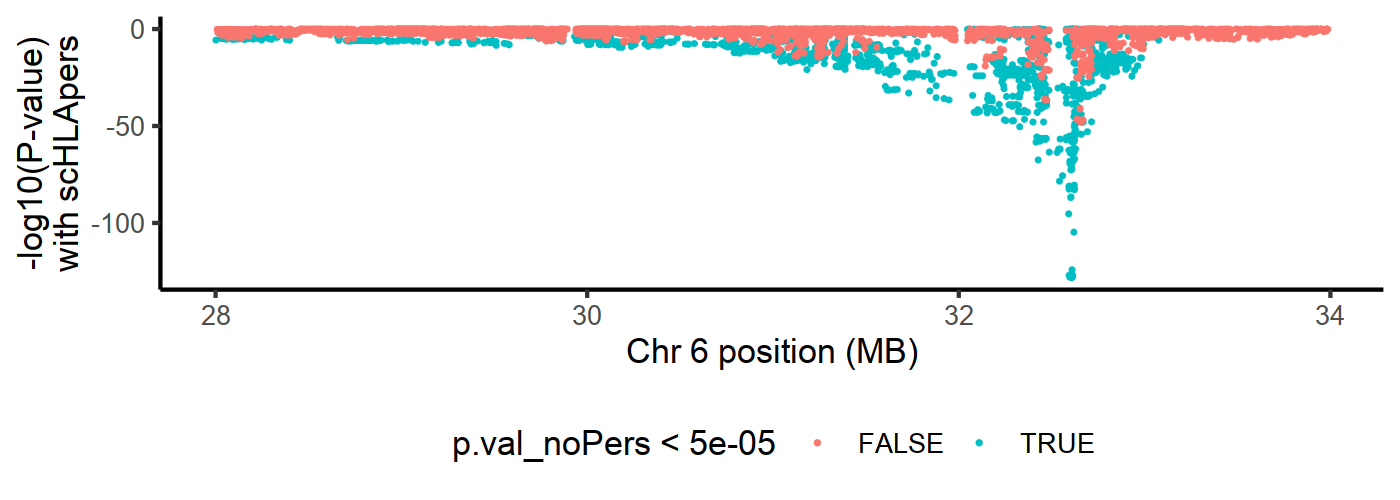

In [7]:
## Plot Manhattan Plot for noPers result, color by whether the result is still significant in scHLApers
fig.size(2.5, 7)
combined_result %>% arrange(p.val_pers > 5e-5) %>%
    filter(gene == 'HLA-DRB1' & cell_type == 'B') %>%
    ggplot() +
    geom_point_rast(aes(x = as.numeric(POS) / 1e6, y = -log10(p.val_noPers), col = p.val_pers < 5e-5), size = 0.3) + 
    theme_classic(base_size = 12) +
    xlab('Chr 6 position (MB)') + ylab('-log10(P-value)\nwith standard pipeline') + theme(legend.position = 'top')

combined_result %>% arrange(p.val_noPers > 5e-5) %>%
    filter(gene == 'HLA-DRB1' & cell_type == 'B') %>%
    ggplot() +
    geom_point_rast(aes(x = as.numeric(POS) / 1e6, y = log10(p.val_pers), col = p.val_noPers < 5e-5), size = 0.3) + 
    theme_classic(base_size = 12) +
    xlab('Chr 6 position (MB)') + ylab('-log10(P-value)\nwith scHLApers') + theme(legend.position = 'bottom')

### Boxplot

The following `from` values were not present in `x`: Smillie2019, Randolph2021, Randolph

The following `from` values were not present in `x`: Smillie2019, Randolph2021, Randolph



png 
  2

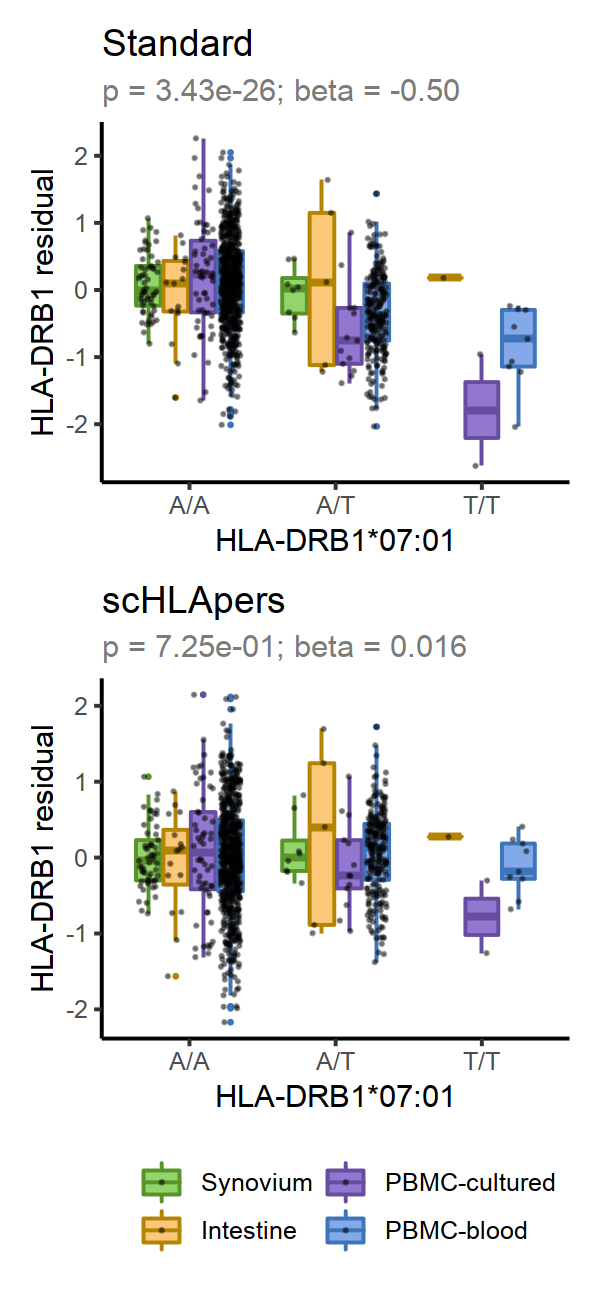

In [8]:
# Standard
sampleXdosage = readRDS('./4_multidataset_eQTLs/B_plasma_sampleXdosage.rds') 
residuals = readRDS('./4_multidataset_eQTLs/B_plasma_residuals_noPers.rds')
colnames(residuals) = str_replace(colnames(residuals), '\\.', '-')
sampleXdosage = sampleXdosage %>% round() %>% as.data.frame()
data = cbind(residuals, sampleXdosage)
p1 = eqtl_boxplot_dataset('HLA_DRB1_07.01', 'HLA-DRB1', data, combined_result, legend = FALSE, noPers = TRUE) +
    xlab('HLA-DRB1*07:01') + ggtitle('Standard')

# scHLApers
residuals = readRDS('./4_multidataset_eQTLs/B_plasma_residuals.rds')
colnames(residuals) = str_replace(colnames(residuals), '\\.', '-')
sampleXdosage = sampleXdosage %>% round() %>% as.data.frame()
data = cbind(residuals, sampleXdosage)
p2 = eqtl_boxplot_dataset('HLA_DRB1_07.01', 'HLA-DRB1', data, combined_result, legend = TRUE, noPers = FALSE) +
    xlab('HLA-DRB1*07:01') + ggtitle('scHLApers') + 
    theme(legend.position = 'bottom') + guides(fill=guide_legend(ncol=2), col=guide_legend(ncol=2)) +
    labs(col = '', fill = '')

fig.size(6.5, 3)
pdf(paste('../SuppFigs/Boxplot_persNoPers_HLA-DRB1_Bcells_DRB1.07.01_eQTL_byDataset.pdf', sep = ''), height=6.5, width=3)
print(p1 / p2)
dev.off()
p1 / p2

The following `from` values were not present in `x`: Smillie2019, Randolph2021, Randolph

The following `from` values were not present in `x`: Smillie2019, Randolph2021, Randolph



png 
  2

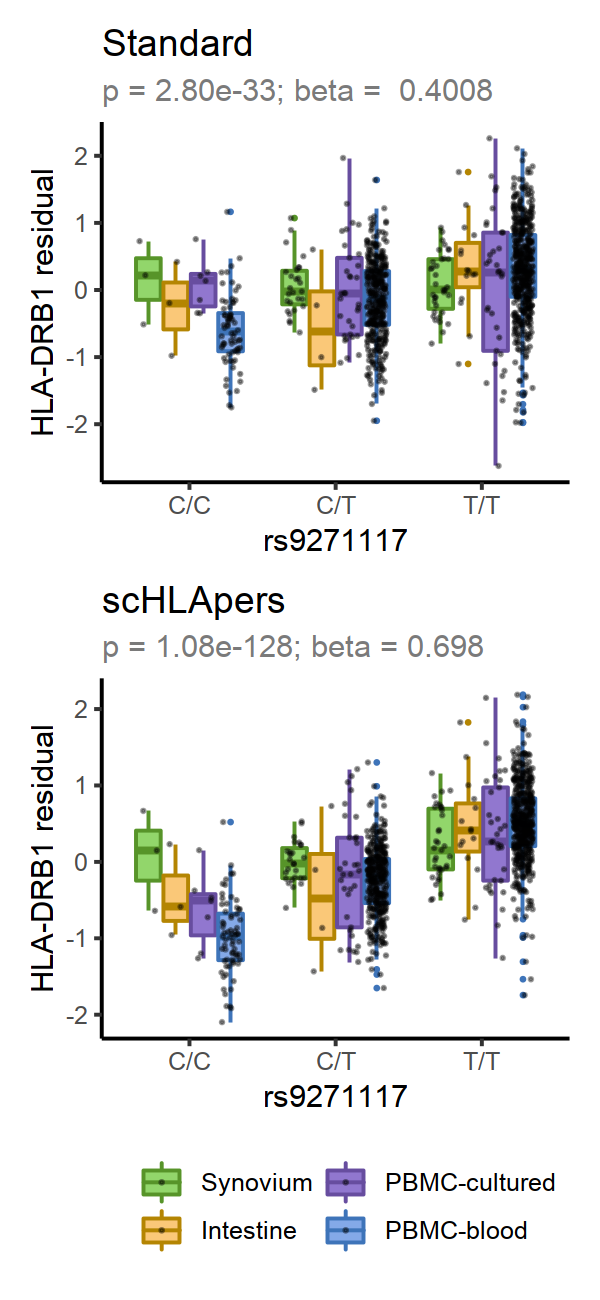

In [9]:
# Standard
sampleXdosage = readRDS('./4_multidataset_eQTLs/B_plasma_sampleXdosage.rds') 
residuals = readRDS('./4_multidataset_eQTLs/B_plasma_residuals_noPers.rds')
colnames(residuals) = str_replace(colnames(residuals), '\\.', '-')
sampleXdosage = sampleXdosage %>% round() %>% as.data.frame()
data = cbind(residuals, sampleXdosage)
p1 = eqtl_boxplot_dataset('rs9271117', 'HLA-DRB1', data, combined_result, legend = FALSE, noPers = TRUE) +
    xlab('rs9271117') + ggtitle('Standard')

# scHLApers
residuals = readRDS('./4_multidataset_eQTLs/B_plasma_residuals.rds')
colnames(residuals) = str_replace(colnames(residuals), '\\.', '-')
sampleXdosage = sampleXdosage %>% round() %>% as.data.frame()
data = cbind(residuals, sampleXdosage)
p2 = eqtl_boxplot_dataset('rs9271117', 'HLA-DRB1', data, combined_result, legend = TRUE, noPers = FALSE) +
    xlab('rs9271117') + ggtitle('scHLApers') +
    theme(legend.position = 'bottom') + guides(fill=guide_legend(ncol=2), col=guide_legend(ncol=2)) +
    labs(col = '', fill = '')

fig.size(6.5, 3)
pdf(paste('../SuppFigs/Boxplot_persNoPers_HLA-DRB1_Bcells_rs9271117_eQTL_byDataset.pdf', sep = ''), height=6.5, width=3)
print(p1 / p2)
dev.off()
p1 / p2

### Manhattan plot

In [10]:
combined_result = combined_result %>% 
    mutate(variant = ifelse(variant == "HLA_DRB1_07.01", "HLA-DRB1*07:01", variant))
toPlot = combined_result %>% filter(gene == 'HLA-DRB1' & cell_type == 'B', 
                                    variant %in% c('HLA-DRB1*07:01', 'rs9271117'))

png 
  2

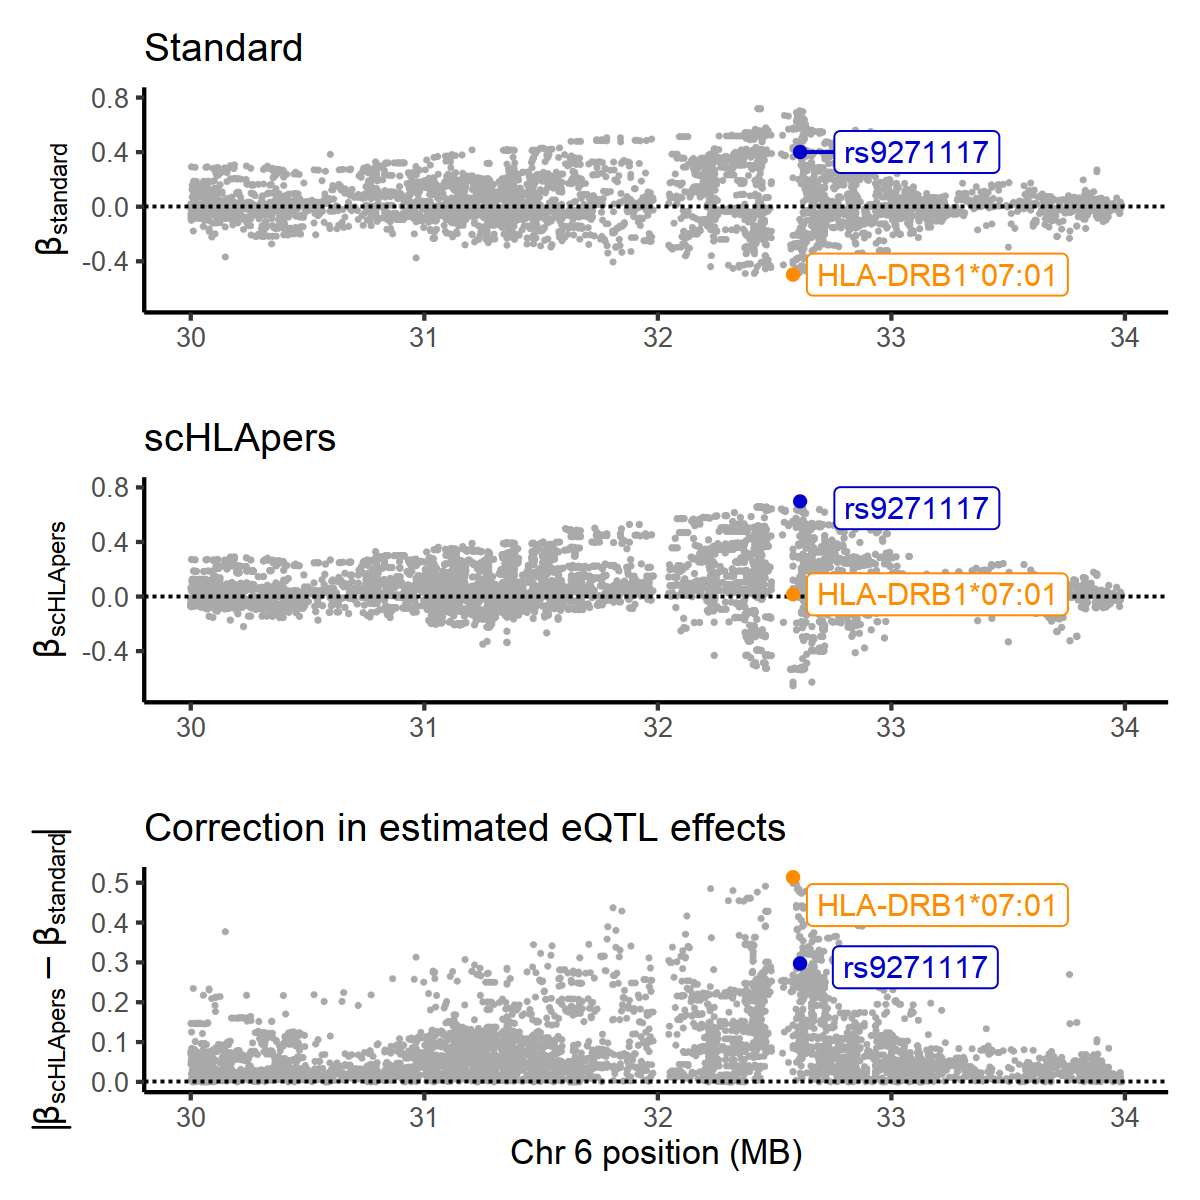

In [11]:
combined_result = combined_result %>% filter(as.numeric(POS) > 30e6 & as.numeric(POS) < 34e6)

my_colors = c("rs9271117" = "mediumblue",
              "HLA-DRB1*07:01" = "darkorange")
a = combined_result %>% 
    filter(gene == 'HLA-DRB1' & cell_type == 'B') %>%
    ggplot() + 
    geom_point(aes(x = as.numeric(POS) / 1e6, y = beta_pers), size = 0.3, col = 'darkgrey') + 
    geom_hline(yintercept = 0, linetype = 'dashed') +
    theme_classic(base_size = 12) + xlab('') + ylab(expression(beta[scHLApers])) + theme(legend.position = 'none') +
    geom_point_rast(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_pers, col = variant)) +
    ggtitle('scHLApers') + scale_color_manual(values = my_colors) + ylim(-0.7, 0.8) +
    geom_label_repel(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_pers, 
                                       col = variant, label = variant), nudge_x = 0.5) +
    theme(plot.title = element_text(size=14))
b = combined_result %>%
    filter(gene == 'HLA-DRB1' & cell_type == 'B') %>%
    ggplot() + 
    geom_point_rast(aes(x = as.numeric(POS) / 1e6, y = beta_noPers), size = 0.3, col = 'darkgrey') + 
    geom_hline(yintercept = 0, linetype = 'dashed') +
    theme_classic(base_size = 12) + xlab('') + ylab(expression(beta[standard])) + theme(legend.position = 'none') +
    geom_point(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_noPers, col = variant)) +
    ggtitle('Standard') + scale_color_manual(values = my_colors) + ylim(-0.7, 0.8) +
    geom_label_repel(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_noPers, 
                                       col = variant, label = variant), nudge_x = 0.5) +
    theme(plot.title = element_text(size=14))
c = combined_result %>%
    filter(gene == 'HLA-DRB1' & cell_type == 'B') %>%
    ggplot() +
    geom_point_rast(aes(x = as.numeric(POS) / 1e6, y = beta_difference), size = 0.3, col = 'darkgrey') + 
    geom_hline(yintercept = 0, linetype = 'dashed') + theme_classic(base_size = 12) +
    theme(legend.position = 'none') + 
    geom_point(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_difference, col = variant)) +
    xlab('Chr 6 position (MB)') + ylab(expression(abs(beta[scHLApers]-beta[standard]))) +
    ggtitle('Correction in estimated eQTL effects') + scale_color_manual(values = my_colors) +
    geom_label_repel(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_difference, 
                                       col = variant, label = variant), nudge_x = 0.5) +
    theme(plot.title = element_text(size=14))
fig.size(6, 6)
pdf(paste0('../SuppFigs/compare_betas_scHLApers_standard_HLA-DRB1_Bcells.pdf'), width = 6, height = 6)
b/a/c
dev.off()
b/a/c

In [12]:
combined_result %>%
    filter(gene == 'HLA-DRB1' & cell_type == 'B') %>% filter(variant %in% c('HLA-DRB1*07:01', 'rs9271117')) %>%
    dplyr::select(variant, cell_type, gene, beta_pers, beta_noPers, p.val_pers, p.val_noPers)

variant        cell_type gene     beta_pers  beta_noPers p.val_pers   
1 HLA-DRB1*07:01 B         HLA-DRB1 0.01619948 -0.4974828   7.252875e-01
2 rs9271117      B         HLA-DRB1 0.69807610  0.4008466  1.075935e-128
  p.val_noPers
1 3.433809e-26
2 2.800652e-33

## HLA-B in T

In [38]:
combined_result$beta_difference = abs(combined_result$beta_pers - combined_result$beta_noPers)
combined_result %>%
    filter(gene == 'HLA-B' & cell_type == 'T') %>% arrange(-abs(beta_difference)) %>% head(4) %>%
    dplyr::select(variant, cell_type, gene, beta_pers, beta_noPers, p.val_pers, p.val_noPers, beta_difference)

variant     cell_type gene  beta_pers  beta_noPers p.val_pers p.val_noPers
1 rs28895004  T         HLA-B 0.01364466 0.6945517   0.83867700 1.531290e-19
2 HLA_B_57.01 T         HLA-B 0.04671721 0.7241641   0.56467419 9.190659e-15
3 HLA_C_06    T         HLA-B 0.09034730 0.7446377   0.07661001 1.561778e-38
4 HLA_C_06.02 T         HLA-B 0.09034730 0.7446377   0.07661001 1.561778e-38
  beta_difference
1 0.6809070      
2 0.6774469      
3 0.6542904      
4 0.6542904

### Boxplot

The following `from` values were not present in `x`: Smillie2019, Randolph2021, Randolph

The following `from` values were not present in `x`: Smillie2019, Randolph2021, Randolph



png 
  2

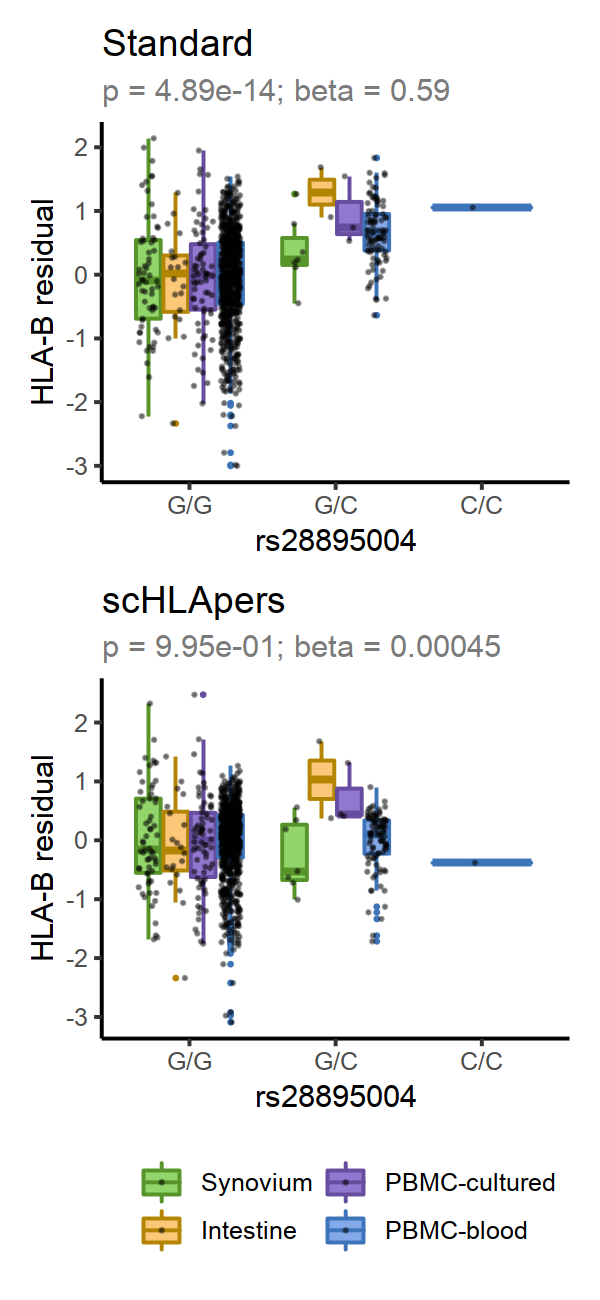

In [39]:
# Standard
sampleXdosage = readRDS('./4_multidataset_eQTLs/T_sampleXdosage.rds') 
residuals = readRDS('./4_multidataset_eQTLs/T_residuals_noPers.rds')
colnames(residuals) = str_replace(colnames(residuals), '\\.', '-')
sampleXdosage = sampleXdosage %>% round() %>% as.data.frame()
data = cbind(residuals, sampleXdosage)
p1 = eqtl_boxplot_dataset('rs28895004', 'HLA-B', data, combined_result, legend = FALSE, noPers = TRUE) +
    ggtitle('Standard')

# scHLApers
residuals = readRDS('./4_multidataset_eQTLs/T_residuals.rds')
colnames(residuals) = str_replace(colnames(residuals), '\\.', '-')
sampleXdosage = sampleXdosage %>% round() %>% as.data.frame()
data = cbind(residuals, sampleXdosage)
p2 = eqtl_boxplot_dataset('rs28895004', 'HLA-B', data, combined_result, legend = TRUE, noPers = FALSE) +
    ggtitle('scHLApers') + 
    theme(legend.position = 'bottom') + guides(fill=guide_legend(ncol=2), col=guide_legend(ncol=2)) +
    labs(col = '', fill = '')

fig.size(6.5, 3)
pdf(paste('../SuppFigs/Boxplot_persNoPers_HLA-B_Tcells_rs28895004_eQTL_byDataset.pdf', sep = ''), height=6.5, width=3)
print(p1 / p2)
dev.off()
p1 / p2

### Manhattan plot

In [40]:
combined_result = combined_result %>% mutate(variant = ifelse(variant == "HLA_B_15", "HLA-B*15", variant))
toPlot = combined_result %>% filter(gene == 'HLA-B' & cell_type == 'T', 
                                    variant %in% c('rs28895004', 'HLA-B*15'))

png 
  2

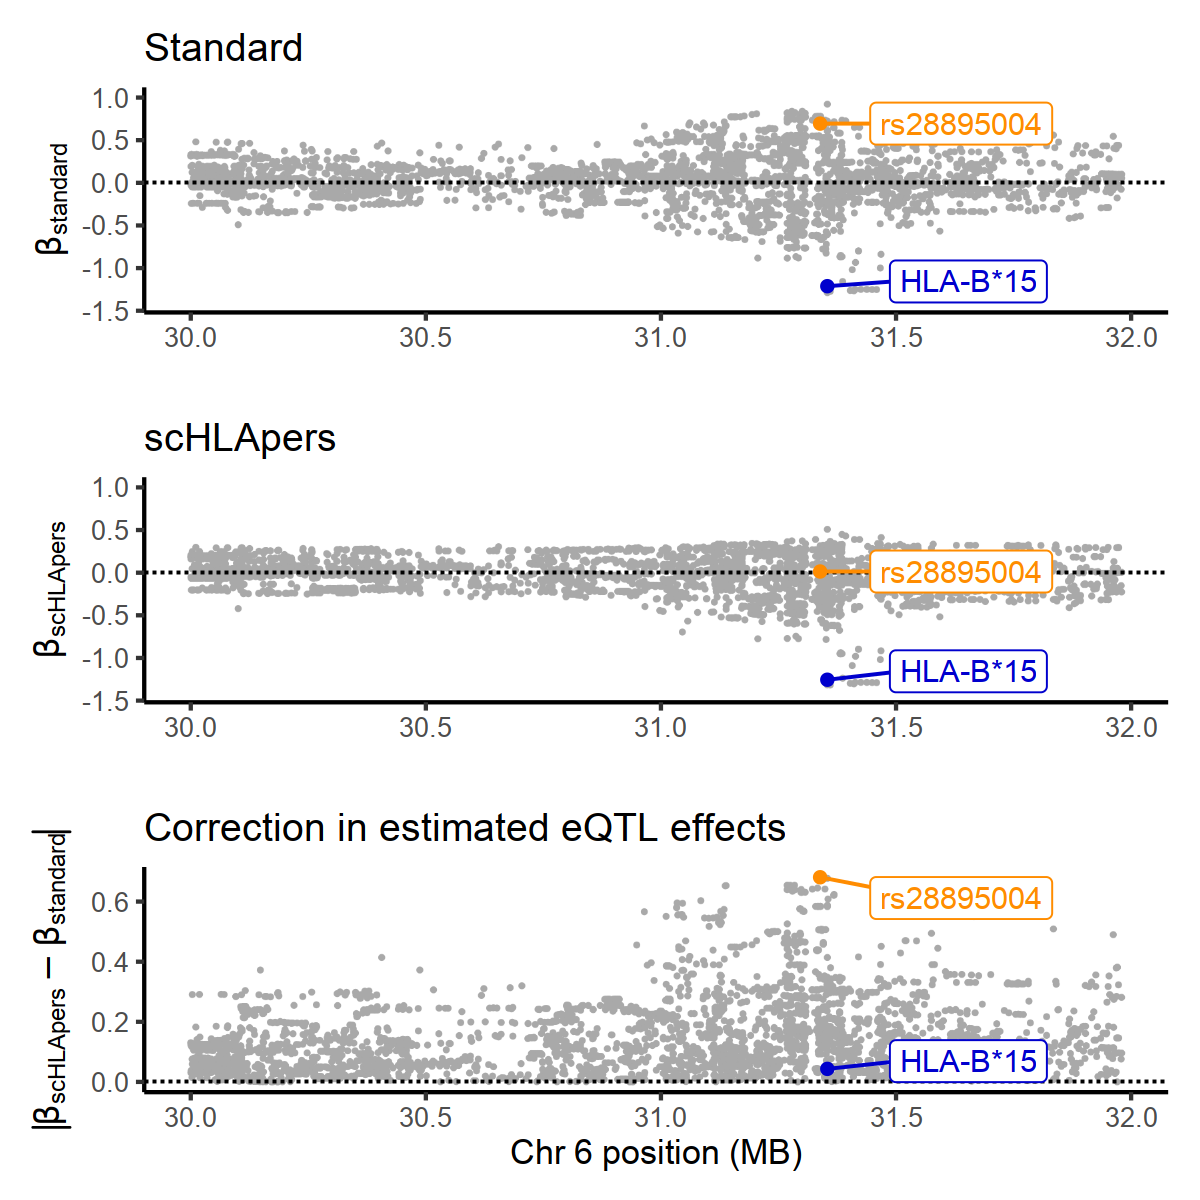

In [41]:
combined_result = combined_result %>% filter(as.numeric(POS) > 30e6 & as.numeric(POS) < 32e6)

my_colors = c("HLA-B*15" = "mediumblue",
              "rs28895004" = "darkorange")

a = combined_result %>% 
    filter(gene == 'HLA-B' & cell_type == 'T') %>%
    ggplot() + 
    geom_point_rast(aes(x = as.numeric(POS) / 1e6, y = beta_pers), size = 0.3, col = 'darkgrey') + 
    geom_hline(yintercept = 0, linetype = 'dashed') +
    theme_classic(base_size = 12) + xlab('') + ylab(expression(beta[scHLApers])) + theme(legend.position = 'none') +
    geom_point(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_pers, col = variant)) +
    ggtitle('scHLApers') + scale_color_manual(values = my_colors) + ylim(-1.4, 1) +
    geom_label_repel(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_pers, 
                                       col = variant, label = variant), nudge_x = 0.3) +
    theme(plot.title = element_text(size=14))
b = combined_result %>%
    filter(gene == 'HLA-B' & cell_type == 'T') %>%
    ggplot() + 
    geom_point_rast(aes(x = as.numeric(POS) / 1e6, y = beta_noPers), size = 0.3, col = 'darkgrey') + 
    geom_hline(yintercept = 0, linetype = 'dashed') +
    theme_classic(base_size = 12) + xlab('') + ylab(expression(beta[standard])) + theme(legend.position = 'none') +
    geom_point(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_noPers, col = variant)) +
    ggtitle('Standard') + scale_color_manual(values = my_colors) + ylim(-1.4, 1) +
    geom_label_repel(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_noPers, 
                                       col = variant, label = variant), nudge_x = 0.3) +
    theme(plot.title = element_text(size=14))
c = combined_result %>%
    filter(gene == 'HLA-B' & cell_type == 'T') %>%
    ggplot() +
    geom_point_rast(aes(x = as.numeric(POS) / 1e6, y = beta_difference), size = 0.3, col = 'darkgrey') + 
    geom_hline(yintercept = 0, linetype = 'dashed') + theme_classic(base_size = 12) +
    theme(legend.position = 'none') + 
    geom_point(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_difference, col = variant)) +
    xlab('Chr 6 position (MB)') + ylab(expression(abs(beta[scHLApers]-beta[standard]))) +
    ggtitle('Correction in estimated eQTL effects') + scale_color_manual(values = my_colors) +
    geom_label_repel(data = toPlot, aes(x = as.numeric(POS) / 1e6, y = beta_difference, 
                                       col = variant, label = variant), nudge_x = 0.3) +
    theme(plot.title = element_text(size=14))
fig.size(6, 6)
pdf(paste0('../SuppFigs/compare_betas_scHLApers_standard_HLA-B_Tcells.pdf'), width = 6, height = 6)
b/a/c
dev.off()
b/a/c

# All done!

In [22]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] coloc_5.1.0.1           readxl_1.3.1            gdata_2.18.0           
 [4] viridis_0.6.2           viridisLite_0.4.1       ggrepel_0.9.1          
 [7] ggrastr_1.0.1           gridExtra_2.3           fitdistrplus_1.1-8     
[10] survival_3.3-1          purrr_